# CSML1010 Project Working Copy
# Sentiment Analysis with the Sentiment140 dataset
## Pete Gray - YorkU #217653247

---------------------------------------------------------

## Introduction

In this project we explore and learn about natural language processing and the lifecycle of machine learning projects. Sentiment analysis will be performed using the Sentiment140 dataset[1]. We will explicity execute data cleaning, data exploration, feature engineering, feature selection, modeling, model selection, and [OTHER STUFF?] The code is mostly assembled from bits and pieces of the coding exercises that are part of the course CSML1010, Fall 2019, at York University, Toronto.

[1] http://help.sentiment140.com/for-students

###### TABLE OF CONTENTS

1. Load data and libraries
2. Data Cleaning
3. Data Exploration
4. Feature Engineering
5. Feature Selection

# Import libraries

In [1]:
import pandas as pd
import numpy as np
np.set_printoptions(precision=2, linewidth=80)
import warnings
warnings.filterwarnings("ignore")
import model_evaluation_utils as meu


# Adjust pandas display

In [2]:
pd.options.display.max_columns = 30
pd.options.display.max_rows = 100
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.precision = 2
pd.options.display.max_colwidth = -1

# Import matplotlib and seaborn and adjust defaults

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 100

import seaborn as sns
sns.set_style("whitegrid")

## Read data from local filesystem and csv source 

In [4]:
df = pd.read_csv("training.1600000.processed.noemoticon.csv", encoding="ISO-8859-1")

Check data with quick visual inspection

In [5]:
df

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
...,...,...,...,...,...,...
1599994,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best feeling ever
1599995,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interviews! â« http://blip.fm/~8bmta
1599996,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me for details
1599997,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! Tupac Amaru Shakur


## Give dataframe columns

In [6]:
df.columns = ['sentiment', 'ID', 'Time', 'none', 'username', 'Text']

In [7]:
df.count()

sentiment    1599999
ID           1599999
Time         1599999
none         1599999
username     1599999
Text         1599999
dtype: int64

### Now it has columns, this seems better.

### Check for nulls in the Text column

In [8]:
df = df[df["Text"].notnull()]
df.count()

sentiment    1599999
ID           1599999
Time         1599999
none         1599999
username     1599999
Text         1599999
dtype: int64

# Set temporary dataset size, for quicker processing

In [9]:
dev_data_size = 1200

In [10]:
start_row = int(800000-(dev_data_size/2))-1
finish_row = int(800000+(dev_data_size/2))-1
df_sm = df[start_row:finish_row]
df_sm.count()

sentiment    1200
ID           1200
Time         1200
none         1200
username     1200
Text         1200
dtype: int64

In [11]:
columns = [col for col in df.columns if not col.startswith('self')]
columns

['sentiment', 'ID', 'Time', 'none', 'username', 'Text']

In [12]:
raw_text = np.array(df_sm['Text'])
sentiments = np.array(df_sm['sentiment'])
raw_text[5:15]

array(['@W_Hancock I am lost. Please help me find a good home. ',
       "@PolluxSJ I hear you... thinking that I'm going to have to take a year off form Burning Man for that very reason ",
       "@thomas_edwards Not until our first issue of the fall. Sorry  I can try to troubleshoot tonight to see why it's not working.",
       "Omg there is soo much traffic!!!! There's never traffic at this time!! ",
       '@tjthetruckdrivr 77000 pounds of sawdust, this aint right  http://myloc.me/5CN2',
       'oh of course, right after i post that, RIP Farrah Fawcett... ',
       '@angiebert  me either lets have a pity party',
       "Pos the last time I'm in the parish for a long time. ",
       "My fish Salinger died! I'm so sad and crying  I love him&lt;3",
       "@christinajade Farrah was a beauty  @antipov Hello! Nice to 'meet' ya!  @Winkfromblueyes you're too kind. TY!"],
      dtype=object)

-----------------------

# =======================
# Data Cleaning
# =======================

-----------------------

## Cleaning function

In [13]:
import re
def clean(s):
    s = s.replace(r'<lb>', "\n")
    s = s.replace(r'<tab>', "\i")
    
    # As a sanity check - s = s.replace(r'W', "Q")
    
    s = re.sub(r'<br */*>', "\n", s)
    s = s.replace("&lt;", "<").replace("&gt;", ">").replace("&amp;", "&")
    s = s.replace("&amp;", "&")
    # markdown urls
    s = re.sub(r'\(https*://[^\)]*\)', "", s)
    # normal urls
    s = re.sub(r'https*://[^\s]*', "", s)
    s = re.sub(r'_+', ' ', s)
    s = re.sub(r'"+', '"', s)
    
    # NUMBERS IN THE TEXT DATA
    # The numbers in the data came to light during feature engineering. 
    # I will try different things here.
    
    # A processor-efficient approach, as suggested at:
    # https://stackoverflow.com/questions/30315035/strip-numbers-from-string-in-python
    # s = s.translate(None, '0123456789')
    # Well, that totally didn't work.
    
    # From the same link, a more conventional, but less efficient approach:
    
    s = re.sub(r'\d+', '', s)
    
    
    # USERNAMES IN THE DATA
    # Let's see if life gets any cleaner with these removed, or if it just blows stuff up.
    # Using code found at: 
    # https://stackoverflow.com/questions/50830214/remove-usernames-from-twitter-data-using-python
    
    s = re.sub('@[^\s]+','',s) 
    
    # Was 4374 for 2000
    # 3593 and 1985
    
    return str(s)

## Observations on the removal of Usernames from data

Running with 2000 rows, Bag of Words came up with 4374 dimensions. This took a dog's age to run through RFE. Applying the removal of usernames (strings beginning with '@') from the text data caused 15 of the 2000 to become null - they were stripped from the dataset. Most significantly, it resulted in a reduction of dimensions at the Bag of Words stage to 3593. While this doesn't appear to enable us to ramp up significantly, it does help.

It is worth noting that there appears to be a bit less gibberish in the selected features after appying this. So, a little quicker, a little cleaner, it's a keeper.

## Create new column in dataframe

In [14]:
df_sm["text_clean"] = ''

# Iterate and clean

In [15]:
for i, row in df_sm.iterrows():
    if i % 1000 == 0:
            print('processed:'.format(i), i)
    df_sm.at[i, "text_clean"] = clean(row.Text)

processed: 800000


### Check results

In [16]:
df_sm.head()

,sentiment,ID,Time,none,username,Text,text_clean
799399,0,2328964240,Thu Jun 25 10:11:30 PDT 2009,NO_QUERY,Sleevo86,Wow... Rest in peace Farrah Fawcett,Wow... Rest in peace Farrah Fawcett
799400,0,2328964537,Thu Jun 25 10:11:31 PDT 2009,NO_QUERY,dobbert21,How pissed am I that I'm missing most of Kevin Burkhardt's play-by-play for work? Very,How pissed am I that I'm missing most of Kevin Burkhardt's play-by-play for work? Very
799401,0,2328964564,Thu Jun 25 10:11:31 PDT 2009,NO_QUERY,queenjord,So sad to hear farrah fawcett died,So sad to hear farrah fawcett died
799402,0,2328964881,Thu Jun 25 10:11:32 PDT 2009,NO_QUERY,prosodic,"RIP Farrah Fawcett. I told my husband a couple days ago that I wondered if she'd live long enough to marry Ryan O'Neal. Sadly, no.","RIP Farrah Fawcett. I told my husband a couple days ago that I wondered if she'd live long enough to marry Ryan O'Neal. Sadly, no."
799403,0,2328965091,Thu Jun 25 10:11:34 PDT 2009,NO_QUERY,dj_diva,@djt_elle &lt;---sadder face cause you leaving and we never hooked up,elle <---sadder face cause you leaving and we never hooked up


## Additional pre-processing: tokenization, removing extra whitespaces, lower casing and more advanced operations like spelling corrections, grammatical error corrections, removing repeated characters.

In [17]:
import nltk
wpt = nltk.WordPunctTokenizer()
nltk.download("stopwords")
stop_words = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Define normalization function

In [18]:
def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

In [19]:
normalize_corpus = np.vectorize(normalize_document)

In [20]:
df_sm["text_normalized"] = ''

In [21]:
for i, row in df_sm.iterrows():
    if i % 1000 == 0:
            print('processed:'.format(i), i)
    df_sm.at[i, "text_normalized"] = normalize_corpus(row.text_clean)

processed: 800000


### check results

In [22]:
df_sm

,sentiment,ID,Time,none,username,Text,text_clean,text_normalized
799399,0,2328964240,Thu Jun 25 10:11:30 PDT 2009,NO_QUERY,Sleevo86,Wow... Rest in peace Farrah Fawcett,Wow... Rest in peace Farrah Fawcett,wow . rest peace farrah fawcett
799400,0,2328964537,Thu Jun 25 10:11:31 PDT 2009,NO_QUERY,dobbert21,How pissed am I that I'm missing most of Kevin Burkhardt's play-by-play for work? Very,How pissed am I that I'm missing most of Kevin Burkhardt's play-by-play for work? Very,pissed im missing kevin burkhardts play - - play work ?
799401,0,2328964564,Thu Jun 25 10:11:31 PDT 2009,NO_QUERY,queenjord,So sad to hear farrah fawcett died,So sad to hear farrah fawcett died,sad hear farrah fawcett died
799402,0,2328964881,Thu Jun 25 10:11:32 PDT 2009,NO_QUERY,prosodic,"RIP Farrah Fawcett. I told my husband a couple days ago that I wondered if she'd live long enough to marry Ryan O'Neal. Sadly, no.","RIP Farrah Fawcett. I told my husband a couple days ago that I wondered if she'd live long enough to marry Ryan O'Neal. Sadly, no.","rip farrah fawcett told husband couple days ago wondered shed live long enough marry ryan ' neal . sadly , ."
799403,0,2328965091,Thu Jun 25 10:11:34 PDT 2009,NO_QUERY,dj_diva,@djt_elle &lt;---sadder face cause you leaving and we never hooked up,elle <---sadder face cause you leaving and we never hooked up,elle -- sadder face cause leaving never hooked
...,...,...,...,...,...,...,...,...
800594,4,1467934550,Mon Apr 06 22:53:05 PDT 2009,NO_QUERY,sugarCookie16,@angiekaybee yep i saw him in february and i get to see @dfcook on may 8th. looking forward to seeing him again,yep i saw him in february and i get to see on may th. looking forward to seeing him again,yep saw february get see may th looking forward seeing
800595,4,1467934615,Mon Apr 06 22:53:06 PDT 2009,NO_QUERY,TheRealJessicaS,@youtube check it out my page subcribe updating soon http://www.youtube.com/user/KoolKidzBlock,check it out my page subcribe updating soon,check page subcribe updating soon
800596,4,1467934702,Mon Apr 06 22:53:07 PDT 2009,NO_QUERY,DjDATZ,really hungry...so i grabbed some ice cream from the freeze.,really hungry...so i grabbed some ice cream from the freeze.,really hungry . grabbed ice cream freeze .
800597,4,1467934706,Mon Apr 06 22:53:08 PDT 2009,NO_QUERY,nanasus,I'm new and lost,I'm new and lost,im new lost


In [23]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [24]:
for i, row in df_sm.iterrows():
    if i % 1000 == 0:
        print(i)
    if(row["text_normalized"] and len(str(row["text_normalized"])) < 1000000):
        doc = nlp(str(row["text_normalized"]))
        adjectives = []
        nouns = []
        verbs = []
        lemmas = []

        for token in doc:
            lemmas.append(token.lemma_)
            if token.pos_ == "ADJ":
                adjectives.append(token.lemma_)
            if token.pos_ == "NOUN" or token.pos_ == "PROPN":
                nouns.append(token.lemma_)
            if token.pos_ == "VERB":
                verbs.append(token.lemma_)
                
        df_sm.at[i, "text_lemma"] = " ".join(lemmas)                
        df_sm.at[i, "text_nouns"] = " ".join(nouns)
        df_sm.at[i, "text_adjectives"] = " ".join(adjectives)
        df_sm.at[i, "text_verbs"] = " ".join(verbs)
        df_sm.at[i, "text_nav"] = " ".join(nouns+adjectives+verbs)
        df_sm.at[i, "no_tokens"] = len(lemmas)

800000


In [25]:
df_sm

,sentiment,ID,Time,none,username,Text,text_clean,text_normalized,text_lemma,text_nouns,text_adjectives,text_verbs,text_nav,no_tokens
799399,0,2328964240,Thu Jun 25 10:11:30 PDT 2009,NO_QUERY,Sleevo86,Wow... Rest in peace Farrah Fawcett,Wow... Rest in peace Farrah Fawcett,wow . rest peace farrah fawcett,wow . rest peace farrah fawcett,peace farrah fawcett,,rest,peace farrah fawcett rest,6.00
799400,0,2328964537,Thu Jun 25 10:11:31 PDT 2009,NO_QUERY,dobbert21,How pissed am I that I'm missing most of Kevin Burkhardt's play-by-play for work? Very,How pissed am I that I'm missing most of Kevin Burkhardt's play-by-play for work? Very,pissed im missing kevin burkhardts play - - play work ?,piss -PRON- be miss kevin burkhardts play - - play work ?,kevin burkhardts play work,,piss be miss play,kevin burkhardts play work piss be miss play,12.00
799401,0,2328964564,Thu Jun 25 10:11:31 PDT 2009,NO_QUERY,queenjord,So sad to hear farrah fawcett died,So sad to hear farrah fawcett died,sad hear farrah fawcett died,sad hear farrah fawcett die,sad farrah fawcett,,hear die,sad farrah fawcett hear die,5.00
799402,0,2328964881,Thu Jun 25 10:11:32 PDT 2009,NO_QUERY,prosodic,"RIP Farrah Fawcett. I told my husband a couple days ago that I wondered if she'd live long enough to marry Ryan O'Neal. Sadly, no.","RIP Farrah Fawcett. I told my husband a couple days ago that I wondered if she'd live long enough to marry Ryan O'Neal. Sadly, no.","rip farrah fawcett told husband couple days ago wondered shed live long enough marry ryan ' neal . sadly , .","rip farrah fawcett tell husband couple day ago wonder shed live long enough marry ryan ' neal . sadly , .",farrah fawcett husband couple day marry ryan neal,,rip tell wonder shed,farrah fawcett husband couple day marry ryan neal rip tell wonder shed,21.00
799403,0,2328965091,Thu Jun 25 10:11:34 PDT 2009,NO_QUERY,dj_diva,@djt_elle &lt;---sadder face cause you leaving and we never hooked up,elle <---sadder face cause you leaving and we never hooked up,elle -- sadder face cause leaving never hooked,elle -- sad face cause leave never hook,elle face cause,sad,leave hook,elle face cause sad leave hook,8.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
800594,4,1467934550,Mon Apr 06 22:53:05 PDT 2009,NO_QUERY,sugarCookie16,@angiekaybee yep i saw him in february and i get to see @dfcook on may 8th. looking forward to seeing him again,yep i saw him in february and i get to see on may th. looking forward to seeing him again,yep saw february get see may th looking forward seeing,yep see february get see may th look forward see,february may,,see see look see,february may see see look see,10.00
800595,4,1467934615,Mon Apr 06 22:53:06 PDT 2009,NO_QUERY,TheRealJessicaS,@youtube check it out my page subcribe updating soon http://www.youtube.com/user/KoolKidzBlock,check it out my page subcribe updating soon,check page subcribe updating soon,check page subcribe update soon,page subcribe,,check update,page subcribe check update,5.00
800596,4,1467934702,Mon Apr 06 22:53:07 PDT 2009,NO_QUERY,DjDATZ,really hungry...so i grabbed some ice cream from the freeze.,really hungry...so i grabbed some ice cream from the freeze.,really hungry . grabbed ice cream freeze .,really hungry . grab ice cream freeze .,ice cream freeze,hungry,grab,ice cream freeze hungry grab,8.00
800597,4,1467934706,Mon Apr 06 22:53:08 PDT 2009,NO_QUERY,nanasus,I'm new and lost,I'm new and lost,im new lost,-PRON- be new lose,,new,be lose,new be lose,4.00


# Sometimes, our cleaning reduces our text to nothing! Which makes a lot of stuff unable to run.

## This hack has been helpful in that regard:

In [26]:
# Save in case we need it later:


df_sm = df_sm[df_sm["text_nav"].notnull()]
df_sm.count()

# shuffle the dataset for later.
# df = df.sample(frac=1)

sentiment          1190
ID                 1190
Time               1190
none               1190
username           1190
Text               1190
text_clean         1190
text_normalized    1190
text_lemma         1190
text_nouns         1190
text_adjectives    1190
text_verbs         1190
text_nav           1190
no_tokens          1190
dtype: int64

----------------------------------------

# Saving Cleaned Data to the Filesystem

### So I can run without re-cleaning, or move a chunk to the Cloud for experiments.

In [27]:
# save cleaned data

df_sm.to_csv('cleaned01.csv', encoding='utf-8', index=False)

# Loading Cleaned Data from the Filesystem

### Saved in various sizes, load as appropriate

In [28]:
# df_sm = pd.read_csv("s140_cln_100k.csv", encoding="utf-8")

## s140_cln_100k.csv

----------------------------

# =========================
# Data Exploration
# =========================

----------------------------

### Is dataset balanced?

We know that the original dataset is split right down the middle, with 800,000 positive documents and 799,999 negative. Let's check that:

In [29]:
df['sentiment'].value_counts()

4    800000
0    799999
Name: sentiment, dtype: int64

Excellent. Now, let's check that our hackishly sampled little subset is also balanced:

In [30]:
df_sm['sentiment'].value_counts()

0    596
4    594
Name: sentiment, dtype: int64

Good. Seems balanced enough for now.

### Show data types in each column

In [31]:
df_sm.dtypes

sentiment          int64  
ID                 int64  
Time               object 
none               object 
username           object 
Text               object 
text_clean         object 
text_normalized    object 
text_lemma         object 
text_nouns         object 
text_adjectives    object 
text_verbs         object 
text_nav           object 
no_tokens          float64
dtype: object

### Summary of numerical features

Not the most useful thing, but helpful as a quick sanity check.

In [32]:
df_sm.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
sentiment,1190.00,2.00,2.00,0.00,0.00,0.00,4.00,4.00
ID,1190.00,1899205965.09,430789059.57,1467822272.00,1467880418.00,2328964388.50,2329090260.00,2329205794.00
no_tokens,1190.00,8.84,5.35,1.00,5.00,8.00,12.00,28.00


### Exploring text at different levels of cleaning

In [33]:
df_sm[['text_clean','text_normalized','text_lemma','text_nav']].sample(10)

,text_clean,text_normalized,text_lemma,text_nav
799597,- I am sorry you aren't having a good day,sorry arent good day,sorry be not good day,day good
799573,"Just got back from a nearby (~mi.) city. It was a fun vacation, although it was short lived for one day.","got back nearby mi .) city . fun vacation , although short lived one day .","get back nearby mi . ) city . fun vacation , although short live one day .",mi city fun vacation day short get live
800297,I'm gunnna do both of those things,im gunnna things,-PRON- be gunnna thing,gunnna thing be
800525,How are you? Was good seeing you @ Lip Service last week!,good seeing lip service last week !,good seeing lip service last week !,seeing lip service week good last
799840,She died? I just read an article the other day saying she was going to marry the guy she's been with for like...ever...sad,died read article day saying going marry guy shes like ... ever ... sad,die read article day say go marry guy -PRON- s like ... ever ... sad,article day marry guy sad die read say go s
800473,The Super Red Diva !!! Stupid University,super red diva ! stupid university,super red diva ! stupid university,diva stupid university red
799776,My guess would be Patrick Swayze -another big loss,guess would patrick swayze another big loss,guess would patrick swayze another big loss,guess loss big would patrick swayze
799787,Rest in peace Farrah Fawcett,rest peace farrah fawcett,rest peace farrah fawcett,peace farrah fawcett rest
799826,"yikes. Luckily, I'm obsessed with those simply asia noodle bowls so I'll just stick to those.",yikes luckily ' obsessed simply asia noodle bowls ' stick .,yike luckily ' obsess simply asia noodle bowls ' stick .,yike asia noodle bowls stick obsess
799645,Finished my paper! It's about creating new discourses about the (Muslim) veil. It's always about how oppressed these women are...,finished paper creating new discourses ( muslim ) veil . ' always oppressed women ...,finished paper create new discourse ( muslim ) veil . ' always oppress woman ...,paper discourse muslim veil woman finished new create oppress


In [34]:
# Import matplotlib and seaborn and adjust some defaults
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 100

import seaborn as sns
sns.set_style("whitegrid")

### Creating a List of Tokens from a List of Documents

In [35]:
def my_tokenizer(text):
    return text.split() if text != None else []

In [36]:
tokens = df_sm.text_nav.map(my_tokenizer).sum()

In [37]:
print(tokens[:200])

['peace', 'farrah', 'fawcett', 'rest', 'kevin', 'burkhardts', 'play', 'work', 'piss', 'be', 'miss', 'play', 'sad', 'farrah', 'fawcett', 'hear', 'die', 'farrah', 'fawcett', 'husband', 'couple', 'day', 'marry', 'ryan', 'neal', 'rip', 'tell', 'wonder', 'shed', 'elle', 'face', 'cause', 'sad', 'leave', 'hook', 'hancock', 'home', 'good', 'lose', 'help', 'find', 'year', 'form', 'man', 'reason', 'hear', 'think', 'go', 'take', 'burn', 'edwards', 'issue', 'troubleshoot', 'tonight', 'first', 'sorry', 'fall', 'try', 'see', 'work', 'traffic', 'traffic', 'time', 'much', 'soo', 'pound', 'sawdust', 'right', 'be', 'post', 'fawcett', 'farrah', 'rip', 'pity', 'party', 'let', 'pos', 'time', 'time', 'last', 'long', 'be', 'parish', 'fish', 'salinger', 'crying', 'love', 'sad', 'die', 'be', 'farrah', 'beauty', 'nice', 'meet', 'farrah', 'hairstyle', 'rip', 'live', 'world', 'icon', 'rest', 'peace', 'ms', 'farrah', 'fawcett', 'god', 'lose', 'miss', 'bless', 'bit', 'writer', 'face', 'sad', 'bump', 'rip', 'charles

### Counting Frequencies with a Counter

In [38]:
from collections import Counter

counter = Counter(tokens)
counter.most_common(20)

[('farrah', 161),
 ('go', 137),
 ('fawcett', 109),
 ('sad', 90),
 ('good', 88),
 ('be', 84),
 ('get', 77),
 ('day', 70),
 ('love', 64),
 ('miss', 57),
 ('work', 56),
 ('want', 53),
 ('time', 52),
 ('rip', 51),
 ('quot', 48),
 ('die', 45),
 ('see', 45),
 ('know', 45),
 ('make', 42),
 ('night', 41)]

In [39]:
print([t[0] for t in counter.most_common(200)]) 

['farrah', 'go', 'fawcett', 'sad', 'good', 'be', 'get', 'day', 'love', 'miss', 'work', 'want', 'time', 'rip', 'quot', 'die', 'see', 'know', 'make', 'night', 'thank', 'today', 's', 'think', 'feel', 'pass', 'new', 'rest', 'peace', 'tonight', 'need', 'hope', 'tomorrow', 'would', 'morning', 'say', 'angel', 'can', 'watch', 'hear', 'come', 'twitter', 'could', 'great', 'try', 'thing', 'lol', 'tell', 'find', 'last', 'u', 'take', 'friend', 'bad', 'leave', 'happy', 'week', 'cancer', 'bed', 'sleep', 'lose', 'let', 'charlie', 'family', 'wish', 'show', 'much', 'eat', 'way', 'look', 'sorry', 'guy', 'may', 'hate', 'hair', 'life', 'read', 'hour', 'glad', 'home', 'man', 'hot', 'hurt', 'tweet', 'wait', 'year', 'news', 'people', 'school', 'haha', 'call', 'fun', 'help', 'head', 'old', 'big', 'use', 'r', 'have', 'play', 'first', 'live', 'icon', 'god', 'fight', 'suck', 'house', 'excited', 'hungry', 'game', 'right', 'post', 'long', 'nice', 'aww', 'tired', 'prayer', 'put', 'break', 'dinner', 'food', 'update',

### Remove stopwords from list of tokens

In [40]:
from spacy.lang.en.stop_words import STOP_WORDS

def remove_stopwords(tokens):
    """Remove stopwords from a list of tokens."""
    return [t for t in tokens if t not in STOP_WORDS]

# rebuild counter
counter = Counter(remove_stopwords(tokens))

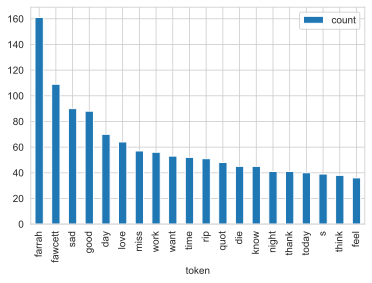

In [41]:
# convert list of tuples into data frame
freq_df = pd.DataFrame.from_records(counter.most_common(20),
                                    columns=['token', 'count'])

# create bar plot
freq_df.plot(kind='bar', x='token');

## Word clouds

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt

In [43]:
from wordcloud import WordCloud

def wordcloud(counter):
    """A small wordloud wrapper"""
    wc = WordCloud(width=1200, height=800, 
                   background_color="white", 
                   max_words=200) 
    wc.generate_from_frequencies(counter)

    # Plot
    fig=plt.figure(figsize=(6, 4))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

#### The Word Cloud!!

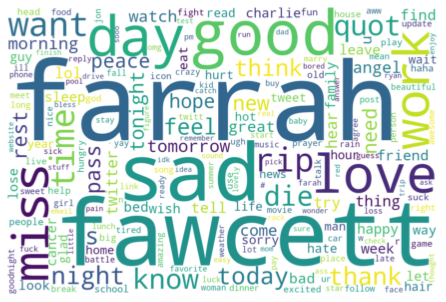

In [44]:
wordcloud(counter)

### Positive words, negative words

Let's do some charts and clouds for exclusively positive or negative samples.

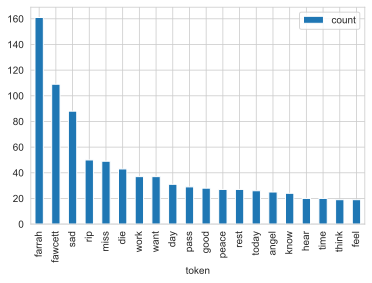

In [45]:
neg_df = df_sm[df_sm['sentiment']==0]
neg_tokens = neg_df.text_nav.map(my_tokenizer).sum()
neg_counter = Counter(neg_tokens)
#neg_counter.most_common(20)
neg_counter = Counter(remove_stopwords(neg_tokens))
neg_freq_df = pd.DataFrame.from_records(neg_counter.most_common(20),
                                    columns=['token', 'count'])

# create bar plot
neg_freq_df.plot(kind='bar', x='token');

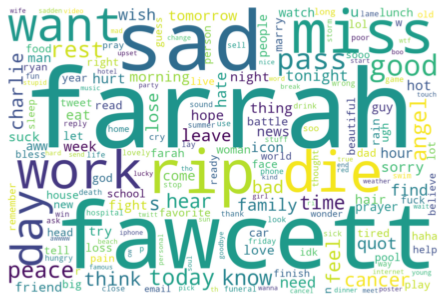

In [46]:
wordcloud(neg_counter)

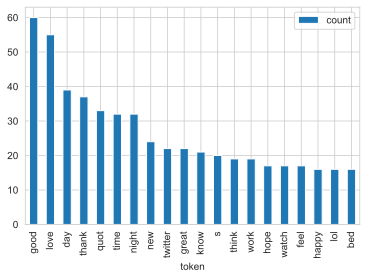

In [47]:
pos_df = df_sm[df_sm['sentiment']==4]
pos_tokens = pos_df.text_nav.map(my_tokenizer).sum()
pos_counter = Counter(pos_tokens)
#pos_counter.most_common(20)
pos_counter = Counter(remove_stopwords(pos_tokens))
pos_freq_df = pd.DataFrame.from_records(pos_counter.most_common(20),
                                    columns=['token', 'count'])

# create bar plot
pos_freq_df.plot(kind='bar', x='token');

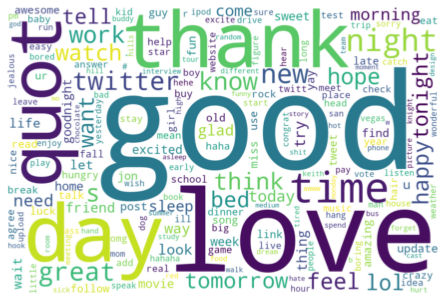

In [48]:
wordcloud(pos_counter)

Well, WOW, those are some mighty positive words, in the positive documents word cloud! 

The most frequently occurring words are clearly different in the text labeled as positive and the text labeled as negative.

In the early phases of development, we were using a dataset, centered around the change at 800,000 rows, with 4000 samples. In this sample, the words "Farrah" and "Fawcett" were the most common words. This suggested perhaps that we need to be more careful about subsampling our data (perhaps a random selection approach would yeild less weird results?) it made for a surprise when we looked at positive and negative sentiment. Who would have thought that "Farrah" and "Fawcett" would be exclusively from statements with negative sentiment? Surprised me, for sure, but there it is. Data Exploration!

## Exploring text complexity

In [49]:
df_sm['no_tokens'] = df_sm.text_lemma\
  .map(lambda l: 0 if l==None else len(l.split()))

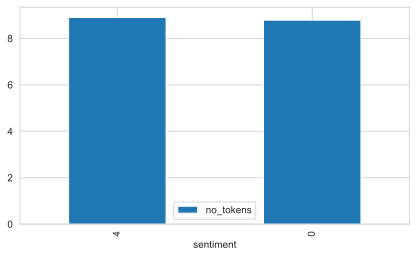

In [50]:
# mean number of tokens by sentiment
df_sm.groupby(['sentiment']) \
  .agg({'no_tokens':'mean'}) \
  .sort_values(by='no_tokens', ascending=False) \
  .plot(kind='bar', figsize=(7,4));

In [51]:
# render plots as retina or png, because svg is very slow
%config InlineBackend.figure_format = 'retina'

import seaborn as sns

def multi_boxplot(data, x, y, ylim = None):
    '''Wrapper for sns boxplot with cut-off functionality'''
    # plt.figure(figsize=(30, 5))
    fig, ax = plt.subplots()
    plt.xticks(rotation=90) 

    # order boxplots by median
    ordered_values = data.groupby(x)[[y]] \
                         .median() \
                         .sort_values(y, ascending=False) \
                         .index
        
    sns.boxplot(x=x, y=y, data=data, palette='Set2', 
                order=ordered_values)

    fig.set_size_inches(11, 6)
    
    # cut-off y-axis at value ylim
    ax.set_ylim(0, ylim)

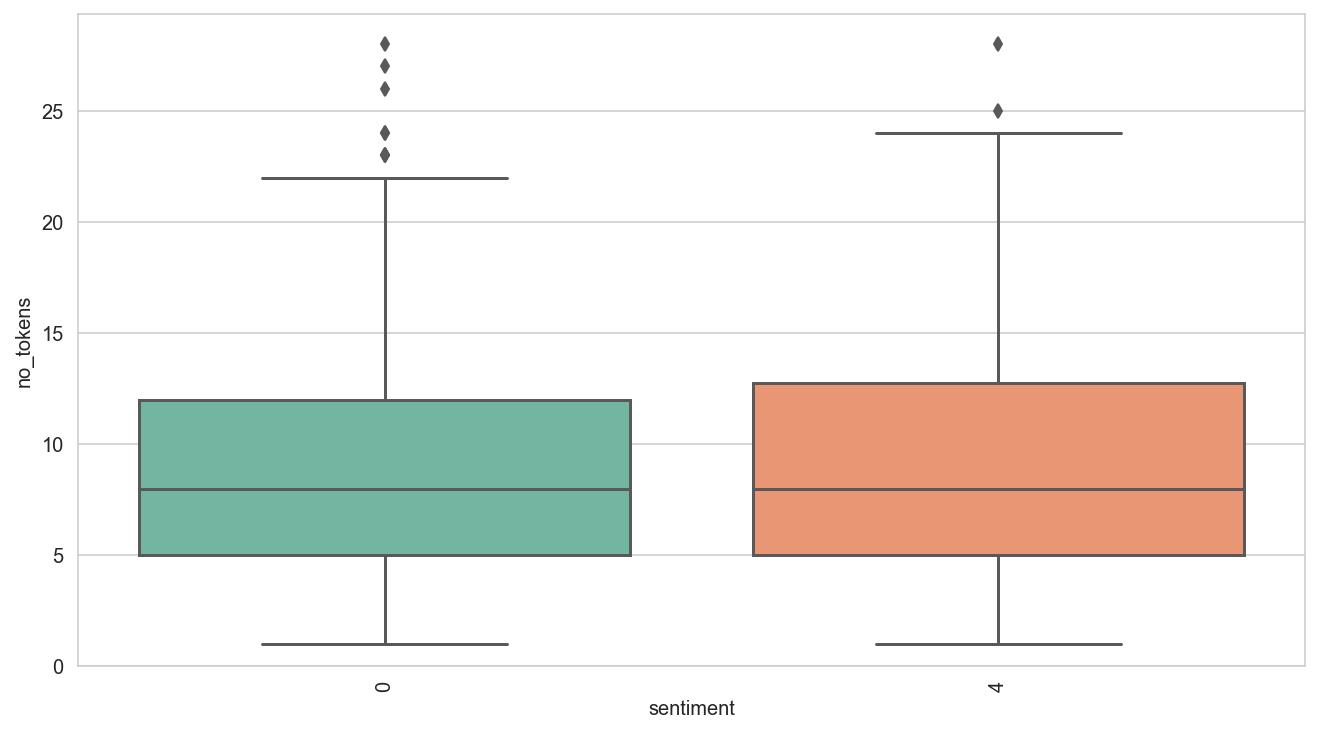

In [52]:
multi_boxplot(df_sm, 'sentiment', 'no_tokens');

In [53]:
# print text of outliers
df_sm['text_lemma'][df_sm.no_tokens > 1500]

Series([], Name: text_lemma, dtype: object)

In [54]:
# cut-off diagram at y=40

# CAREFUL!!! this isn't that meaningful, and it takes for freaking ever to plot, even with only 4000 rows!!!

# multi_boxplot(df_sm, 'username', 'no_tokens', ylim=40)

------------------------------------------

# ===============================
# Feature Engineering
# ===============================

--------------------------------------------

Feature Engineering and Feature Selection are part of the Data Preparation stage of the CRISP-DM methodology. After data has been cleaned and explored, it must be transformed from raw, unstructured text into a structured numeric format that can be used as inputs for our models. Simpler Data Engineering techniques focus on vectorizing individual words, with little emphasis on the contexts of the words. We use Bag of Words and Bag of N-Grams to explore these simpler approaches. While easy to use, and not terribly demanding in terms of computer power required, these techniques are fundamentally less powerful than more modern, processor intensive techniques that concern themselves more with the context of the words. We use pre-trained word embeddings for our advanced feature engineering efforts, in order to avoid computational bottlenecks. If time allows, we may attempt to train our own embedding at some point.

### A vector space model is simply a mathematical model to represent unstructured text (or any other data) as numeric vectors, such that each dimension of the vector is a specific feature\attribute.

## Bag of Words Model

The bag of words model represents each text document as a numeric vector where each dimension is a specific word from the corpus and the value could be its frequency in the document, occurrence (denoted by 1 or 0) or even weighted values. The model’s name is such because each document is represented literally as a ‘bag’ of its own words, disregarding word orders, sequences and grammar.

In [55]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(min_df=0., max_df=1.)
cv_matrix = cv.fit_transform(df_sm['text_nav'])
cv_matrix = cv_matrix.toarray()
cv_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [56]:
# get all unique words in the corpus
vocab_bagowords = cv.get_feature_names()
# show document feature vectors
pd.DataFrame(cv_matrix, columns=vocab_bagowords)

,aaaand,aaawwww,aaru,abay,abc,ability,able,academy,access,account,accountant,ace,ache,ack,ackin,...,yike,ym,young,youth,youtube,you½re,yr,yrold,yrs,yum,yvonne,zealand,zhen,zone,zta
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1185,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1186,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1187,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1188,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Micro dataframe visualization experiment

To satisfy my curiosity, I'm going to make up a teeny weeny little dataframe, to see if I can see some values in one of these arrays as it gets previewed here in the pandas dataframe thing. We just see the corners. All zeroes. Let's see if it looks more satisfying with just a handful of rows...

In [57]:
df_micro = df_sm[1:10]
cv_micro = CountVectorizer(min_df=0., max_df=1.)
cv_micro_matrix = cv_micro.fit_transform(df_micro['text_nav'])
cv_micro_matrix = cv_micro_matrix.toarray()
cv_micro_matrix

array([[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 

In [58]:
# get all unique words in the corpus
vocab_micro = cv_micro.get_feature_names()
# show document feature vectors
pd.DataFrame(cv_micro_matrix, columns=vocab_micro)

,be,burkhardts,burn,cause,couple,day,die,edwards,elle,face,fall,farrah,fawcett,find,first,...,see,shed,soo,sorry,take,tell,think,time,tonight,traffic,troubleshoot,try,wonder,work,year
0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,...,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0
3,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1
6,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,...,1,0,0,1,0,0,0,0,1,0,1,1,0,1,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,2,0,0,0,0,0
8,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Oh, that's much more gratifying!

While it's clearly useless from a practical perspective, it's nice to be able to see some numbers that aren't zeroes and let me know that the code is doing the thing I expect the code to be doing. I've got to try this on the next ones, too!

## Bag of N-Grams model

A word is just a single token, often known as a unigram or 1-gram. We already know that the Bag of Words model doesn’t consider order of words. But what if we also wanted to take into account phrases or collection of words which occur in a sequence? N-grams help us achieve that. An N-gram is basically a collection of word tokens from a text document such that these tokens are contiguous and occur in a sequence. Bi-grams indicate n-grams of order 2 (two words), Tri-grams indicate n-grams of order 3 (three words), and so on. The Bag of N-Grams model is hence just an extension of the Bag of Words model so we can also leverage N-gram based features. The following example depicts bi-gram based features in each document feature vector.

In [59]:
# you can set the n-gram range to 1,2 to get unigrams as well as bigrams
bv = CountVectorizer(ngram_range=(2,5))
bv_matrix = bv.fit_transform(df_sm['text_nav'])

bv_matrix = bv_matrix.toarray()
vocab_ngrams = bv.get_feature_names()
pd.DataFrame(bv_matrix, columns=vocab_ngrams)

,aaaand portfolio,aaaand portfolio time,aaaand portfolio time enough,aaaand portfolio time enough make,aaawwww farrah,aaawwww farrah ri,aaawwww farrah ri die,aaawwww farrah ri die miss,aaru hithavaru,aaru hithavaru ninage,aaru hithavaru ninage moovarolage,aaru hithavaru ninage moovarolage vote,abay sa,abay sa kasal,abay sa kasal veil,...,zealand year rain,zealand year rain day,zealand year rain day india,zhen thing,zhen thing planet,zhen thing planet odd,zhen thing planet odd little,zone tweet,zone tweet morning,zone tweet morning pm,zone tweet morning pm different,zta due,zta due wks,zta due wks work,zta due wks work day
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1185,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1186,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1187,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1188,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


This gives us feature vectors for our documents, where each feature consists of a bi-gram representing a sequence of two words and values represent how many times the bi-gram was present for our documents.

### And now with the Micro Dataframe:

In [60]:
bv_micro = CountVectorizer(ngram_range=(2,2))
bv_micro_matrix = bv_micro.fit_transform(df_micro['text_nav'])

bv_micro_matrix = bv_micro_matrix.toarray()
vocab_micro = bv_micro.get_feature_names()
pd.DataFrame(bv_micro_matrix, columns=vocab_micro)

,be miss,burkhardts play,cause sad,couple day,day marry,edwards issue,elle face,face cause,fall try,farrah fawcett,fawcett hear,fawcett husband,first sorry,form man,go take,...,sawdust right,see work,sorry fall,take burn,tell wonder,think go,time much,tonight first,traffic time,traffic traffic,troubleshoot tonight,try see,wonder shed,work piss,year form
0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,1,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
3,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1
6,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,...,0,1,1,0,0,0,0,1,0,0,1,1,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# TF-IDF Model

There are some potential problems which might arise with the Bag of Words model when it is used on large corpora. Since the feature vectors are based on absolute term frequencies, there might be some terms which occur frequently across all documents and these may tend to overshadow other terms in the feature set. The TF-IDF model tries to combat this issue by using a scaling or normalizing factor in its computation. TF-IDF stands for Term Frequency-Inverse Document Frequency. There are multiple variants of this model but they all end up giving quite similar results.

In [61]:
from sklearn.feature_extraction.text import TfidfVectorizer

tv = TfidfVectorizer(min_df=0., max_df=1., use_idf=True)
tv_matrix = tv.fit_transform(df_sm['text_nav'])
tv_matrix = tv_matrix.toarray()

vocab_tfidf = tv.get_feature_names()
pd.DataFrame(np.round(tv_matrix, 2), columns=vocab_tfidf)

,aaaand,aaawwww,aaru,abay,abc,ability,able,academy,access,account,accountant,ace,ache,ack,ackin,...,yike,ym,young,youth,youtube,you½re,yr,yrold,yrs,yum,yvonne,zealand,zhen,zone,zta
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1185,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1186,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1187,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1188,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


### Gotta try that with the Micro Dataframe...

In [62]:
tv_micro = TfidfVectorizer(min_df=0., max_df=1., use_idf=True)
tv_micro_matrix = tv_micro.fit_transform(df_micro['text_nav'])
tv_micro_matrix = tv_micro_matrix.toarray()

vocab_micro = tv_micro.get_feature_names()
pd.DataFrame(np.round(tv_micro_matrix, 2), columns=vocab_micro)

,be,burkhardts,burn,cause,couple,day,die,edwards,elle,face,fall,farrah,fawcett,find,first,...,see,shed,soo,sorry,take,tell,think,time,tonight,traffic,troubleshoot,try,wonder,work,year
0,0.28,0.33,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.28,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.51,0.00,0.00,0.00,0.00,0.43,0.43,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.30,0.30,0.00,0.00,0.00,0.00,0.00,0.25,0.25,0.00,0.00,...,0.00,0.30,0.00,0.00,0.00,0.30,0.00,0.00,0.00,0.00,0.00,0.00,0.30,0.00,0.00
3,0.00,0.00,0.00,0.42,0.00,0.00,0.00,0.00,0.42,0.42,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.41,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.34,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.34,0.00,0.34,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.34
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.32,0.00,0.00,0.32,0.00,0.00,0.00,0.32,...,0.32,0.00,0.00,0.32,0.00,0.00,0.00,0.00,0.32,0.00,0.32,0.32,0.00,0.27,0.00
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.38,0.00,0.00,0.00,0.00,0.38,0.00,0.76,0.00,0.00,0.00,0.00,0.00
8,0.44,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


--------------------------------------

# ===========================
# Feature Selection
# ===========================

--------------------------------------

Feature Selection is an essential step, which allows us to identify which features are most important to the predictive abilities of our models. Filter methods of Feature Selection involve looking at individual features in isolation, giving them a score by which they can be ranked in terms of their usefulness. We use Univariate Chi-squared statistical tests. Wrapper methods of Feature Selection consider sets of features in combination, which can give deeper insights into which features to select given their interactions and correlations with one another. We use Recursive Feature Elimination and Bagged Decision Trees for this type of feature selection. There are also Embedded Feature Selection techniques, however, these are done in concert with the modeling phase of the project, and if they will be attempted, they will be attempted during the modeling phase of the project.

## Filter Method

### The scikit-learn library provides the SelectKBest class that uses the chi squared (chi^2) statistical test to select the best features

Our Bag of Words vectorization has provided us with over a thousand features. SelectKBest can identify which of these features are most strongly correlated with our sentiment label. We produce a new Bag of Words containing only the features SelectKBest determines are most important.

In [63]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
# select the 500 features that have the strongest correlation to a class from the
# original thousands of features
selector = SelectKBest(chi2, k=500)
selected_features = \
bow_selected = selector.fit(cv_matrix, df_sm['sentiment']).get_support(indices=True)
selected_features

array([   9,   19,   20,   27,   30,   32,   35,   39,   50,   58,   59,   62,
         66,   69,   81,   87,   99,  104,  112,  129,  130,  131,  133,  135,
        139,  147,  168,  169,  170,  173,  174,  176,  178,  181,  182,  184,
        189,  193,  197,  205,  210,  212,  215,  217,  229,  231,  233,  235,
        238,  241,  250,  251,  254,  256,  257,  258,  259,  275,  284,  287,
        294,  305,  309,  315,  317,  328,  329,  334,  335,  342,  344,  359,
        361,  365,  370,  374,  385,  394,  400,  407,  410,  411,  413,  418,
        425,  427,  446,  453,  454,  461,  469,  472,  473,  479,  482,  484,
        485,  489,  491,  493,  496,  504,  508,  512,  518,  545,  554,  560,
        568,  573,  574,  575,  577,  587,  602,  606,  610,  611,  616,  618,
        619,  625,  626,  631,  637,  643,  645,  648,  649,  652,  678,  680,
        690,  708,  709,  710,  712,  726,  733,  734,  738,  743,  744,  751,
        752,  753,  757,  759,  763,  768,  773,  77

## Interpreting the Selected Features

That array of numbers tells us which indecies of the Bag of Words vectorization were deemed most important by SelectKBest. Kind of boring on its own. It would be much more gratifying to see the actual words it has decided are most important.

## View list of words selected by SelectKBest

In [64]:
for x in selected_features:
    print(vocab_bagowords[x], end=' ')

account add addict afraid age agree ahhh aid alexa amazing american anal angel animal answer appreciate artistic asleep attack awesome awful aww awww awwww baby bad battle baumarkt bb be beach beat beautiful become bed beer believe beyonce bike black bless blessing blog blue boo book boom border boring bottle boy boyfriend brand brave brazil break breakfast brother buddy buffy bummed bus busy buy bye cancel cancer car card carry cast challenge chance charlie check cheese chocolate church class client close clothe club coffee college com congrat cook cookie core count country couple crack crappy crazy cream creek cross cruise cry cure cute cvs dad death dentist design di die diego different dinner discover dog donnie double doubt drag draw dread drink drinking drunk dun dvd early easter easy ed entertain entire error excellent excite excited exciting face faith fall family farah farrah favorite fawcett fawcetts fb feather feed felt fight final find finish follow freakin friday fuck fudg

## Wrapper Method

### Recursive Feature Elimination

The Recursive Feature Elimination (or RFE) method works by recursively removing attributes and building a model on those attributes that remain. It uses the model accuracy to identify which attributes (and combination of attributes) contribute the most to predicting the target attribute.

In [65]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

In [66]:
model = LogisticRegression(solver='lbfgs', max_iter=6)
rfe = RFE(model, 500)
fit = rfe.fit(cv_matrix, df_sm['sentiment'])
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

Num Features: 500
Selected Features: [False False False ... False False False]
Feature Ranking: [ 246 1918 1103 ...  727 1318  368]


In [67]:
i=0
for x in fit.support_:
    if x:
        print(vocab_bagowords[i], end=' ')
    i=i+1

account adam add addict afraid agree aid amazing angel animal answer appreciate argue artistic ask asleep ass assignment attack attractive awake awesome awful aww awww baby bad battle bb be beach beat bed believe bike black blessing blog blue bog bonjour boo book boom border bored boring bothwell bottle bout boy boyfriend brand brate brazil break breakfast bridge brother buddy burning business busy butt buy bye cancel cancer car card carry cast ce challenge chance change charlie chat check cheese chocolate church class clean close clothe coffee college com congrat cook cookie core could couple crack crappy crazy cream creek cross cry cvs dad damn dentist design di die diego different dinner discover do dog donnie double doubt draag drag dread drink drinking drive drunk dump dun dvd early earth easter easy eat email endless entertain entire error excite excited exciting face fail faith fall family fan farah farrah favorite fawcett feed feel felt fight finish finished flu follow food fri

## More Wrapper Methods

## Bagged Decision Trees - ExtraTreesClassifier classifier class

In [68]:
from sklearn.ensemble import ExtraTreesClassifier

In [69]:
# feature extraction
model_bagged = ExtraTreesClassifier(n_estimators=10)
model_bagged.fit(cv_matrix, df_sm['sentiment'])
# np.set_printoptions(threshold=np.inf)
print(model_bagged.feature_importances_)
# np.set_printoptions(threshold=200)

[9.55e-04 1.08e-05 9.91e-06 ... 0.00e+00 0.00e+00 2.17e-04]


In [70]:
i=0
n=0
min_imp = 0.00041
min_starred = 0.004
for x in model_bagged.feature_importances_:
    if x>min_imp:
        if x>min_starred:
            print('***', end='')
        print(vocab_bagowords[i], end=' ')
        n=n+1
    i=i+1
print(' ')
print(' ')
print('Number of Features with minimum importance ', min_imp, ': ', n)

aaaand ability able ad add afraid afternoon agree ahahah ahhhh allow amazing andrewcilley ***angel angels annoy answer arne aroundd art ass austin austrian awake awesome awful aww awww babiiesss background backup ***bad battle ***be beach beautiful ***bed begin believe big black blackberrys boo boring boss boy boyfriend brand break bridge broadway brush brussels bubba bunny burn bus butt buy bye ca california call can cancel cancer car care caro carry cat cd celery central centrelink challenge chance change charlie cheer cheers chest chicago chilling chocolate cider city coffee com come complekate confuse congrat cool could coupon crap crappy cry cut cw cybercommand cyrus dad dam damn dang ***day daylol ddi death decide deck depeche ***die dinner direct disappointed do donnie drain dread dream drink drive dude dun dundrum dunno easter easy eat egypt employe end english erin esurance everyone excite excited expect eye face fall family fan fancy farah ***farrah favorite ***fawcett feel f

## Note that the stars ( *** ) denote features that were given much higher importances.

## Feature Selection on TF-IDF encoded features

### Filter Method - SelectKBest

In [71]:
selector_tfidf = SelectKBest(chi2, k=500)
selected_features_tfidf = \
selector_tfidf.fit(tv_matrix, df_sm['sentiment']).get_support(indices=True)
selected_features_tfidf

array([   9,   16,   19,   20,   27,   30,   32,   35,   36,   45,   58,   59,
         62,   66,   73,   76,   81,   86,   87,   99,  100,  104,  112,  129,
        130,  131,  133,  135,  147,  157,  165,  168,  170,  174,  176,  178,
        182,  184,  189,  197,  205,  207,  208,  210,  212,  215,  217,  218,
        229,  231,  233,  235,  237,  238,  250,  251,  254,  256,  257,  259,
        275,  279,  284,  294,  315,  317,  328,  329,  334,  335,  342,  353,
        357,  359,  361,  362,  365,  370,  372,  374,  376,  385,  394,  400,
        407,  411,  413,  418,  427,  434,  445,  446,  453,  454,  461,  469,
        472,  473,  482,  485,  489,  491,  493,  496,  503,  504,  512,  518,
        521,  543,  545,  546,  553,  554,  560,  568,  573,  574,  575,  596,
        602,  604,  606,  616,  618,  619,  622,  625,  626,  631,  643,  645,
        648,  649,  652,  657,  658,  678,  680,  690,  708,  709,  710,  712,
        726,  733,  738,  743,  744,  747,  751,  75

In [72]:
for x in selected_features_tfidf:
    print(vocab_tfidf[x], end=' ')

account actress add addict afraid age agree ahhh ahhhh al amazing american anal angel anne announce answer apply appreciate artistic ashh asleep attack awesome awful aww awww awwww bad balcony bash battle bb beach beat beautiful bed beer believe bike black blackberrys blame bless blessing blog blue blush boo book boom border bored boring boy boyfriend brand brave brazil breakfast brother brussels buddy bummed buy bye cancel cancer car card carry cel centrelink challenge chance change charlie check cheer cheese chicago chocolate church class client clothe club coffee com common confuse congrat cook cookie core count country couple crappy cream creek cross cruise cry cupcakes cure cvs dad dam dead death debby denise dentist design di die diego different dnt dog dollar donnie drag draw dread dreamz drink drinking drunk dvd early easter easy ed effect effin entertain entire error excellent excite excited exciting face faith family farah farrah faucett favorite fawcett fawcetts fawset fb fe

## RFE on TF-IDF vectors 

In [73]:
model_tfidf = LogisticRegression(solver='lbfgs', max_iter=6)
rfe = RFE(model_tfidf, 500)
fit_tfidf = rfe.fit(tv_matrix, df_sm['sentiment'])
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

Num Features: 500
Selected Features: [False False False ... False False False]
Feature Ranking: [ 246 1918 1103 ...  727 1318  368]


In [74]:
i=0
for x in fit_tfidf.support_:
    if x:
        print(vocab_bagowords[i], end=' ')
    i=i+1

account add addict afraid age agree ahhhh al amazing american angel answer appreciate aroundd art artistic ask asleep ass attack awesome awful aww awww awwww baby bad battle bb be beach beat beautiful bed believe black blackberrys blessing blog blue blush boo book boom border bored boring boy boyfriend brand brazil break breakfast brother brussels buddy buy bye cancel cancer car card carry cat cel challenge chance change charlie check cheer cheese chicago chocolate class close clothe coffee college com confuse congrat cook cookie core could couple crap crappy crazy cream creek cross cruise cry cupcakes cute cvs dad dam damn death debby dentist design di die diego different dinner dnt do dog dollar donnie doubt drag draw dread drink drinking drive drunk dvd early easter easy eat ed effect effin email entertain entire error excite excited exciting fabulous face facebook faith fall family farah farrah favorite fawcett feel felt fight figure find finish follow food freakin friday friend fr

# Selecting TF-IDF Features with Bagged Decision Trees

### This represents our most sophisticated feature selection method, being used with our most sophisticated feature engineering method.

Earlier, in the Feature Engineering section, we vectorized our text data using the Term Frequency - Inverse Document Frequency method. This resulted in our documents being represented as vectors with thousands of dimensions. Here we will select the most statistically relevant dimensions using a Wrapper Method known as an Extra Trees Classifier, which is an example of Bagged Decision Trees. 

In [75]:
model_bagged_tfidf = ExtraTreesClassifier(n_estimators=20)
model_bagged_tfidf.fit(tv_matrix, df_sm['sentiment'])
# np.set_printoptions(threshold=np.inf)
print(model_bagged_tfidf.feature_importances_)
# np.set_printoptions(threshold=200)

[1.84e-04 0.00e+00 0.00e+00 ... 2.82e-05 0.00e+00 9.33e-05]


In [76]:
i=0
n=0
min_imp = 0.00040
min_starred = 0.003
for x in model_bagged_tfidf.feature_importances_:
    if x>min_imp:
        if x>min_starred:
            print('***', end='')
        print(vocab_tfidf[i], end=' ')
        n=n+1
    i=i+1
print(' ')
print(' ')
print('Number of Features with minimum importance ', min_imp, ': ', n)

able ad adam add addict afford afraid afternoon agree ahhhh ai album amazing andrewcilley ***angel ankle answer anxious arizona arne aroundd art asia ask asleep ass attack awesome awful aww awww babysitting backup ***bad banana barrie battle ***be beach bed believe black blackberrys blew blog bog bomb bonjour boo bored boring bowls boy boyfriend break bridge broadway brussels bubba business buy bye ca call can cancel ***cancer candid car care carless caro cel chance change ***charlie chat cheer chill cider city close cobra coffee college com come computer confuse congrat cool ***could couple crack crap crappy crazy cry cut cw ***dad dam damn dang darn ***day daylol death ***die dinner discourse dnt do double drain dread drink drive dude dun dundrum dungeon dunno early eat edwards email employe endless english enjoy ento eurotrash excite ***excited eye face fall family fan fancy farah ***farrah ***favorite ***fawcett fawke fear ***feel fellow felt fight find finish finished flu follow f

# A record and summary of 6 types of Feature Selection

## Because I WILL be dropping RFE for being too intensive.

### Running with 3000 samples gave us vectors with around 5000 dimensions. After much running time, we were able to visually inspect the 500 most important features, as selected by each method. It is perhaps not informative to look at, and compare, these lists of features - but it is fun. And it may give some "subconscious" intuition into that age-old question, "What are these things thinking?" So, before I disable some of these, so I can run bigger datasets through all this code, here's a record of this activity, in the comments/markdown.

I will, quite simple, strip the top two and bottom two rows of each output, and paste them here with clear labels. Pretty sure I won't be running RFE going forward - spins forever, with a pretty low number of samples.

#### SelectKBest with Bag of Words
account actress add age agree ahhh airport amazing american angel animal anne anniversary announce answer appreciate arm arrive attend awesome awful aww awww back bad battle beach beautiful bed bedtime beer believe beloved beyonce birthday blog blonde blue boo book boy boyfriend brand brave britney bro ... tomorrow tongue toooo tragic trust tt tuesday tweet twilight twin twit twitter ugh ughhh unc unfair update updates upgrade upload upset ur use vacuum vegas version voice vote wait walters want warped wat watch way wayne website welcome window wish woke woman wonderful woop work wrist wrong wtf xd xoxo yay young youth yup
#### RFE with Bag of Words
aargh account add addict address afraid age agree ahhh air airport album amazing angel anniversary answer app arm arrive artistic attack attend attention awesome awful awsome aww baby back bad bag battle bc beach bed bet big birthday bit blib blog blue bonjour boo bore bored boy boyfriend brain brand break ... tragic true trust tuesday tv tweeting twin twit twitter ugh unc understand unfair updates upgrade upload upset vacation vegas version vibe video vote wait walmart wanna want wat watch way wayne welcome whole whyyyy wife win wish woke wonder wonderful woop word work working world write wrong wtf xavier xd yay young yup
#### Extra Trees Forest with Bag of Words
able account add addict afraid age agree ahhhh air album alex amazing angel apettite arm art audrey awesome awful aww baby back bad bag battle bc be beach beautiful bed begin beloved big bit blaaaaarg blache blog boo bore boy boyfriend break bubba bug burn bus bye call can cancel cancer car care cat cause ... twitter ugh ughh uncle unfair unusual upgrade upgradeable upload upset upsetting ur use vacation vibe vote wait wake walk wanna want warm warning watch way weather wee week weekend welcome well wholee will wish wishing woke woman wonderful work working world would wrong xoxo yay yeanot year yesterday young yup zoo
#### SelectKBest with TF-IDF
account actress add adore age agree ahaha ahhh airport amazing american anal angel anne anniversary announce annoying answer apologize appreciate arm arrive attend awesome awful awsome aww back background bad bag battle beach beautiful beauty bed bedtime beer beie believe beloved bestie beyonce birthday ... touchy tragic trust tuesday tweetie twilight twin twit twitt twitter ugh ughhh unc uncle understand unfair updates upload upset upsetting use va vegas version view voice vote wait wallpaper want watch way website welcome westney window wish woke woman wonderful woo work wrong xd xoxo yay yayyy young youth yup zoo 
#### RFE with TF-IDF
able account add address afraid age agree ahhh airport album amazing american angel anne anniversary answer appreciate arm arrive art attention awesome awful awsome aww back background bad bag battle bc be beach bed believe big birthday bit blog blue bonjour boo book bore bout boy boyfriend brand brb break bro ... upsetting va vacation vegas version vibe vote wait walk wanna want watch way wee welcome whole window wish wishing woke wonder wonderful word work working world wrong wtf xoxo yay young yud yup zoo
#### Extra Trees Forest with TF-IDF
able actress add addict afraid age agree ahhhh airport alex amazing andrewcilley angel apettite arm art awesome awful aww baby back bad battle bc be beach beautiful bed believe beloved big bit blaaaaarg blache blackberrys blog boo book bore bowls boy boyfriend break brussels bubba bug bunny burn butterfly ... upgrade upgradeable upload upset upsetting ur use vacation vegas vibe video wait wake walk walmart wanna want warm warning watch way weather wee week weekend welcome well whole wholee will window wish wishing woke woman wonderful word work working world worried would wrong xoxo yay yeanot year yesterday young yud yup yuri zoo  



## Last but (maybe) not least - Selecting with our Bag-of-N-Grams

#### Comparing features for Bag-o-words and TF-IDF was very much like comparing apples with apples.

This is going to look a little different, I'll bet, so I'll keep it out from between those two.

In [77]:
# select the 50 features that have the strongest correlation to a class from the
# original thousands of features
selector_ngrams = SelectKBest(chi2, k=400)
selected_features_ngrams = \
ngrams_selected = selector_ngrams.fit(bv_matrix, df_sm['sentiment']).get_support(indices=True)
selected_features_ngrams

array([   87,    88,    89,    90,   268,   269,   270,   284,   300,   368,
         557,   600,   689,   784,   791,   851,   857,   916,   941,   978,
        1045,  1547,  1548,  1710,  1714,  1728,  1732,  1789,  1967,  1991,
        2503,  2832,  2884,  2927,  2966,  3148,  3165,  3572,  3580,  3991,
        3992,  4059,  4086,  4104,  4112,  4116,  4117,  4119,  4129,  4142,
        4143,  4146,  4157,  4158,  4167,  4178,  4179,  4203,  4206,  4215,
        4219,  4232,  4239,  4245,  4248,  4251,  4253,  4254,  4270,  4282,
        4325,  4375,  4379,  4385,  4444,  4445,  4448,  4464,  4482,  4483,
        4487,  4501,  4510,  4511,  4521,  4534,  4535,  4577,  4580,  4592,
        4597,  4613,  4621,  4628,  4632,  4637,  4639,  4640,  4651,  4665,
        4740,  4801,  4836,  4839,  5155,  5417,  5448,  5455,  5571,  5628,
        5635,  5653,  5662,  5697,  5716,  5729,  5793,  5827,  5847,  5871,
        5924,  5936,  5995,  6093,  6109,  6114,  6213,  6561,  6629,  6637,

In [78]:
for x in selected_features_ngrams:
    print(vocab_ngrams[x], end=' -       - ')

afternoon thank -       - afternoon thank leaving -       - afternoon thank leaving sad -       - afternoon thank leaving sad theresa -       - angel farrah -       - angel farrah fawcett -       - angel farrah fawcett original -       - angel peace -       - angel sad -       - answer find -       - aww farrah -       - awwww farrah -       - bad feel -       - battle cancer -       - battle cancer sad -       - be feel -       - be get -       - beach day -       - beautiful rip -       - bed night -       - believe die -       - bummed farrah -       - bummed farrah fawcett -       - can believe -       - can believe die -       - can wait -       - can wait see -       - cancer sad -       - charlie angel -       - charlie angel sad -       - couple day -       - day day -       - day marry -       - day sad -       - day sun -       - die miss -       - die think -       - eat want -       - ed mcmahon -       - family friend -       - family friend sad -       - farah fawcett -  

 -       - year man amazing lucky give -       - year rain -       - year rain day -       - year rain day india -       - year rain day india test -       - year sport -       - year sport game -       - year sport game determined -       - year sport game determined interested -       - yearslol know -       - yeheeyyy karma -       - yeheeyyy karma gone -       - yep point -       - yep point easy -       - yep point easy make -       - yeplol bored -       - yeplol bored edward -       - yeplol bored edward hunting -       - yeplol bored edward hunting guy -       - yess phone -       - yess phone twitter -       - yessirrr power -       - yessirrr power da -       - yessirrr power da summah -       - yessirrr power da summah much -       - yesterday musik -       - yesterday musik quot -       - yesterday musik quot transformer -       - yesterday musik quot transformer movie -       - yesterday pay -       - yesterday pay hike -       - yesterday pay hike nice -       - yesterday

# RFE with Bag of N-Grams?

## Sorry, no.

## RFE takes a fabulously long time, even with a few thousand vectors with a few thousand dimensions.

My bag-o-n-grams has 2-grams, 3-grams, and 4-grams. It's kinda fun. With 3000 samples, it has TENS of THOUSANDS of dimensions. I think RFE, in general, won't play a big role in my plans. I suppose I could run this on a few hundred samples to see if it works. But so what if it does? Can't move ahead with any constructive with dinky little dataframes like that. 

# Let's do the forest with the ngrams and call it a day.

In [79]:
model_bagged_ngrams = ExtraTreesClassifier(n_estimators=20)
model_bagged_ngrams.fit(bv_matrix, df_sm['sentiment'])
# np.set_printoptions(threshold=np.inf)
print(model_bagged_ngrams.feature_importances_)
# np.set_printoptions(threshold=200)

[0. 0. 0. ... 0. 0. 0.]


In [80]:
i=0
n=0
min_imp = 0.00041
min_hilite = 0.0028
for x in model_bagged_ngrams.feature_importances_:
    if x>min_imp:
        if x>min_hilite:
            print('|||--', end="")
            print(vocab_ngrams[i], end='--||| -       - ')
        else:
            print(vocab_ngrams[i], end=' -       - ')
        n=n+1
    i=i+1
print(' ')
print(' ')
print('Number of Features with minimum importance ', min_imp, ': ', n)

actress favorite -       - afraid nasty be go -       - ahhhh fall -       - al team -       - andrewcilley service -       - angel good -       - angel sad -       - angels trio -       - answer find -       - arizona annoy like -       - aroundd good -       - aroundd good lay feel -       - art time -       - ashh miss -       - ashh miss funny -       - awful little -       - aww farrah -       - aww sad -       - aww thank -       - bad feel -       - bad sure -       - bad sure come -       - bah pass -       - balcony hawaii -       - balcony hawaii miss -       - barrie bad sure -       - battle cancer -       - be leave -       - be loner -       - be need -       - beach day -       - beautiful rip -       - bed night -       - black white tired get -       - blackberrys fritz -       - blush make -       - bog twitter -       - boyfriend miss -       - brave sad -       - bubba butterfly -       - bubba butterfly mad -       - butterfly mad -       - california close sound c

 -       - rip miss -       - rip see -       - ryan oneal -       - sad american -       - sad announce go -       - sad be -       - |||--sad die--||| -       - sad farah -       - sad farrah -       - sad farrah fawcett -       - sad farrah fawcett hear -       - sad go -       - sad know -       - sad pass -       - sad peace -       - sad rip -       - sad sad -       - sad sleep -       - sad young -       - sam rachel -       - san diego -       - say screw -       - school today -       - scratch pool -       - scratch pool today -       - sedang confuse -       - sense game make -       - series new -       - shift work -       - show chilly -       - sick get -       - smile make -       - song quot -       - sooo hot -       - sooo hot work -       - sooooooo idk tired -       - sooooooo idk tired be -       - sorry be -       - sound flag -       - spring break -       - stevens yep -       - stinkin cute -       - sunburn lovely -       - sunburn lovely daylol -       - su

# Milestone 1 - Conclusion

### Data has been loaded, cleaned, saved, and explored.

### Feature Engineering has been carried out using Bag of Words, Bag of N-Grams, and TF-IDF (Term Frequency - Inverse Document Frequency)

### Three Feature Selection methods, Select K Best, Recursive Feature Elimination, and Bagged Decision Trees, have been carried out on the engineered features.


Dec 14 2019

# Beginning of Milestone 2

Working models.

## Model Selection

### In this section we will train and test models using 4 different algorithms, and then compare their accuracy.

This can help us understand which type of models works best with our data, and allow us to identify problems using certain types of models with our data.

In [81]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df_sm['text_nav'], df_sm['sentiment'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

#clf = MultinomialNB().fit(X_train_tfidf, y_train)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [82]:
print(clf.predict(count_vect.transform(["AArgh, this is the silliest thing ever"])))

[4]


In [83]:
print(clf.predict(count_vect.transform(["I absolutely love this code."])))

[4]


In [84]:
print(clf.predict(count_vect.transform(["Not sure what I think of this one."])))

[4]


In [85]:
print(clf.predict(count_vect.transform(["Why would you do that?"])))

[0]


In [165]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import cross_val_score


models = [
    DecisionTreeClassifier(criterion='entropy', max_depth=2),
    KNeighborsClassifier(n_neighbors=1),
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
    
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, tv_matrix, df_sm['sentiment'], scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

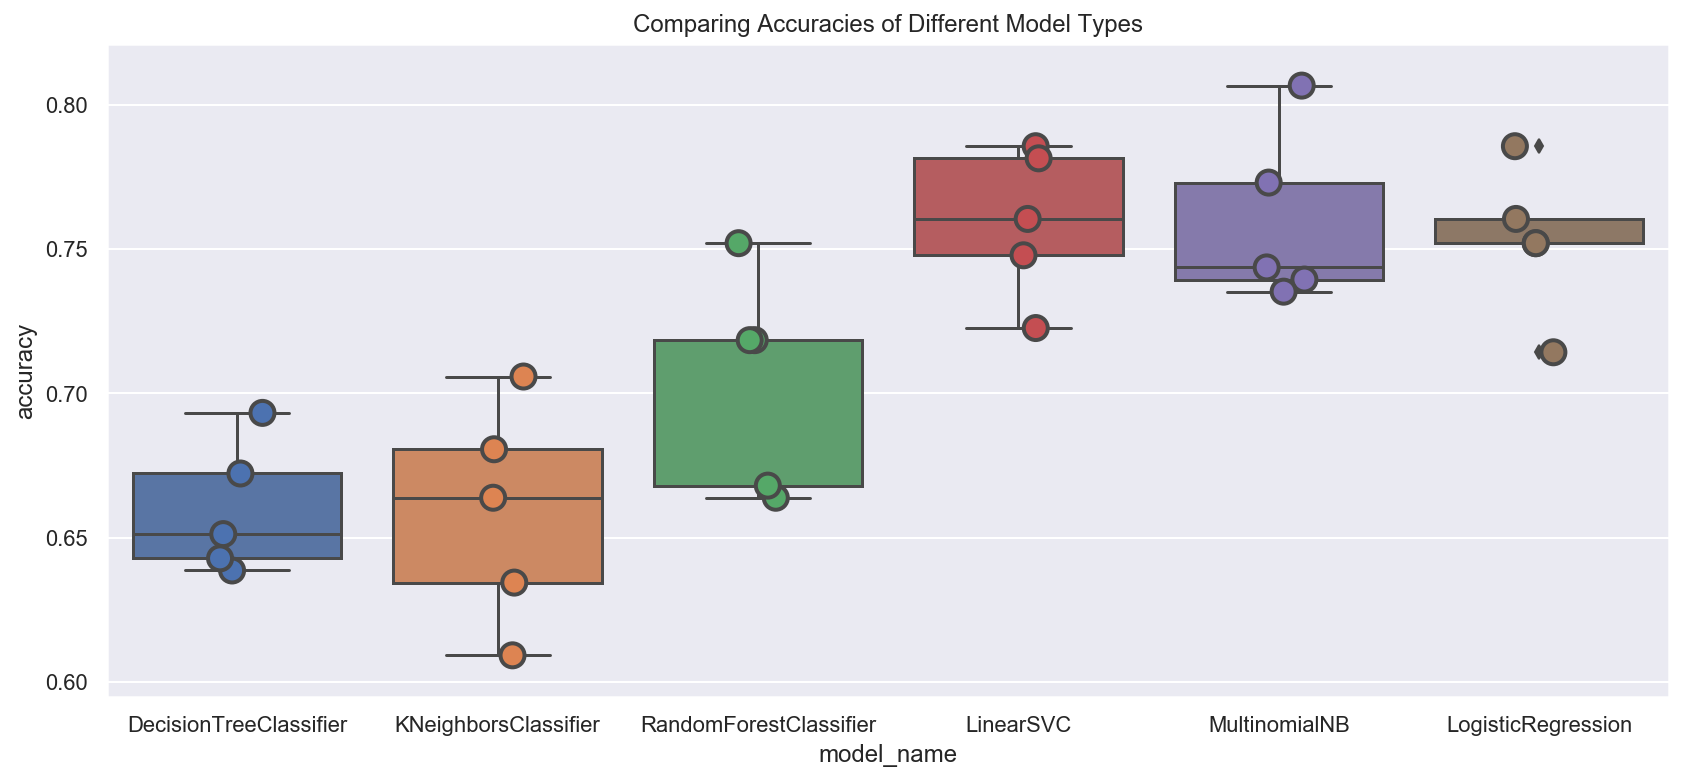

<Figure size 1152x432 with 0 Axes>

In [169]:
import seaborn as sns

sns.set(rc={'figure.figsize':(14,6)})

sns.boxplot(x='model_name', y='accuracy', data=cv_df, width=0.8).set_title('Comparing Accuracies of Different Model Types')
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=12, jitter=True, edgecolor="gray", linewidth=2)
plt.figure(figsize=(16, 6))
#plt.set_size_inches(18.5, 10.5)
plt.savefig('test2png.png', dpi=100)
plt.show()


In [172]:
cv_df.groupby('model_name').accuracy.mean()

model_name
DecisionTreeClassifier   0.66
KNeighborsClassifier     0.66
LinearSVC                0.76
LogisticRegression       0.75
MultinomialNB            0.76
RandomForestClassifier   0.70
Name: accuracy, dtype: float64

## Observation:

My first attempts at Ensembling yielded pretty dubious results. More dubious than some of these standalone models. Looking at this graphs helps explain why - the code I was originally using for Ensemble Methods used Decision Tree and K-Nearest-Neighbour. This graph suggests that these models perform poorly compared to SVC, NB, etc. Which gives us something to go on, in our quest to make the Ensemble Methods produce better results - Ensemble more powerful models!

# ====================================

# LinearSVC (<i>Support Vector Classifier</i>) Model

Split into training and test sets, train model on training set, generate predictions on test set.

In [217]:
from sklearn.model_selection import train_test_split

model_svc = LinearSVC()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(tv_matrix, df_sm['sentiment'], df_sm.index, test_size=0.33, random_state=0)
model_svc.fit(X_train, y_train)
y_pred = model_svc.predict(X_test)

# Confusion Matrix: LinearSVC

Calculate, and display, true positives, true negatives, false positives, and false negatives.

We'll show both the raw matrix, and a "Heatmap", which looks cool, but doesn't give too much insight with only two labels.

RAW CONFUSION MATRIX 

[[127  62]
 [ 39 165]] 

Because the heatmap may LOOK cool, but doesn't tell us much, with only two labels 

--------------------

Heatmap of Consfusion Matrix:


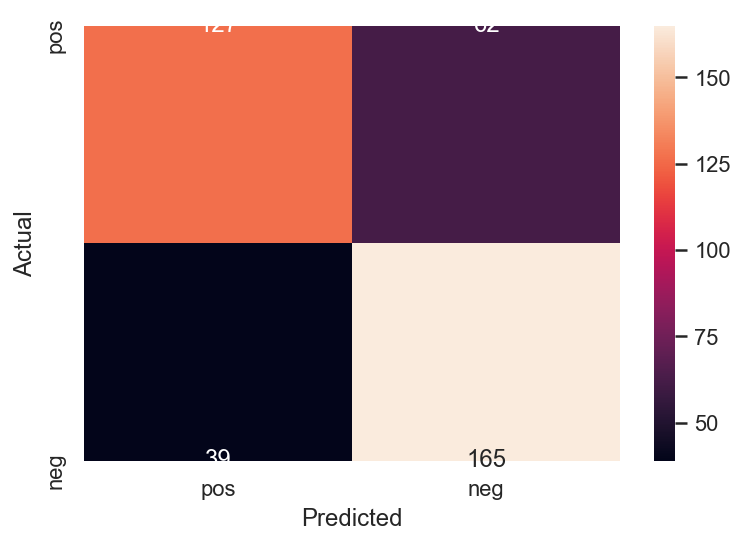

In [218]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
print('RAW CONFUSION MATRIX', '\n')
print(conf_mat, '\n')
print('Because the heatmap may LOOK cool, but doesn\'t tell us much, with only two labels \n')
print('--------------------\n')
print('Heatmap of Consfusion Matrix:')
fig, ax = plt.subplots(figsize=(6,4))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=['pos','neg'], yticklabels=['pos','neg'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [219]:
model_svc.fit(tv_matrix, df_sm['sentiment'])

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

## Precision, Recall and f1-Score: LinearSVC

In [220]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, 
                                    target_names=['0','4']))

              precision    recall  f1-score   support

           0       0.77      0.67      0.72       189
           4       0.73      0.81      0.77       204

    accuracy                           0.74       393
   macro avg       0.75      0.74      0.74       393
weighted avg       0.75      0.74      0.74       393



# ROC Curve: LinearSVC

Using code and wisdom from https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

A useful tool when predicting the probability of a binary outcome is the <b>Receiver Operating Characteristic curve</b>, or ROC curve.

It is a plot of the false positive rate (x-axis) versus the true positive rate (y-axis) for a number of different candidate threshold values between 0.0 and 1.0. Put another way, it plots the false alarm rate versus the hit rate.

No Skill: ROC AUC=0.500
LinearSVC: ROC AUC=0.831

ROC Curve for LinearSVC Classifier:


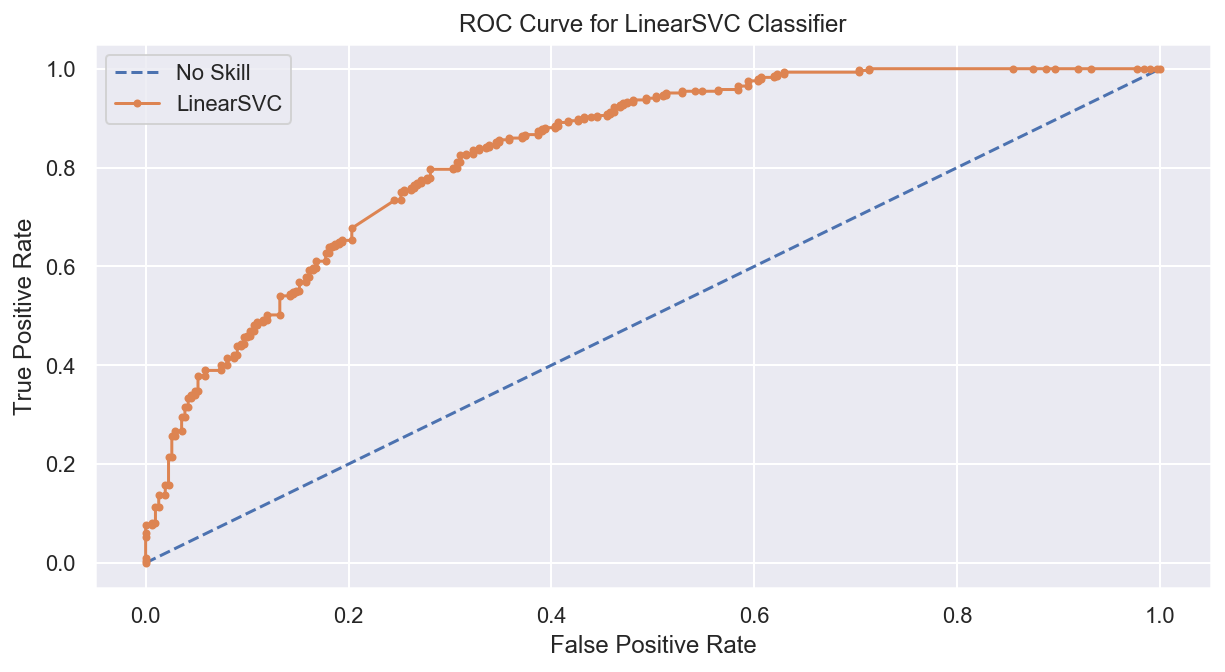

In [221]:
# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

# Shrink back our Seaborn graph size - don't need it as big as we had for the accuracy comparison.
sns.set(rc={'figure.figsize':(10,5)})

# generate 2 class dataset
#X, y = make_classification(n_samples=1000, n_classes=2, random_state=1)
X = tv_matrix
y = df_sm['sentiment']
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(testy))]
# fit a model
# model = LogisticRegression(solver='lbfgs')

# We use our model as defined above
model_svc.fit(trainX, trainy)
# predict probabilities
# use _predict_proba_lr(testX) with SVC
lr_probs = model_svc._predict_proba_lr(testX)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
lr_auc = roc_auc_score(testy, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('LinearSVC: ROC AUC=%.3f' % (lr_auc))
print('\nROC Curve for LinearSVC Classifier:')
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs, pos_label=4)
lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs, pos_label=4)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='LinearSVC')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title('ROC Curve for LinearSVC Classifier')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

This ROC curve shows considerably higher "skill" than the "no skill" curve, which represents the perfomance of a classifier that just guesses the most likely thing.

# AUC - Area Under the Curve

The "skill" of this model can be represented by the AUC score - the Area Under the Curve - and we do note that despite the LinearSVC model having the highest accuracy and f1-score of the models we tried, Logistic Regression appears to have a higher AUC, as we will see below.

## Precision-Recall Curve: LinearSVC Model

LinearSVC: f1=0.846 auc=0.899


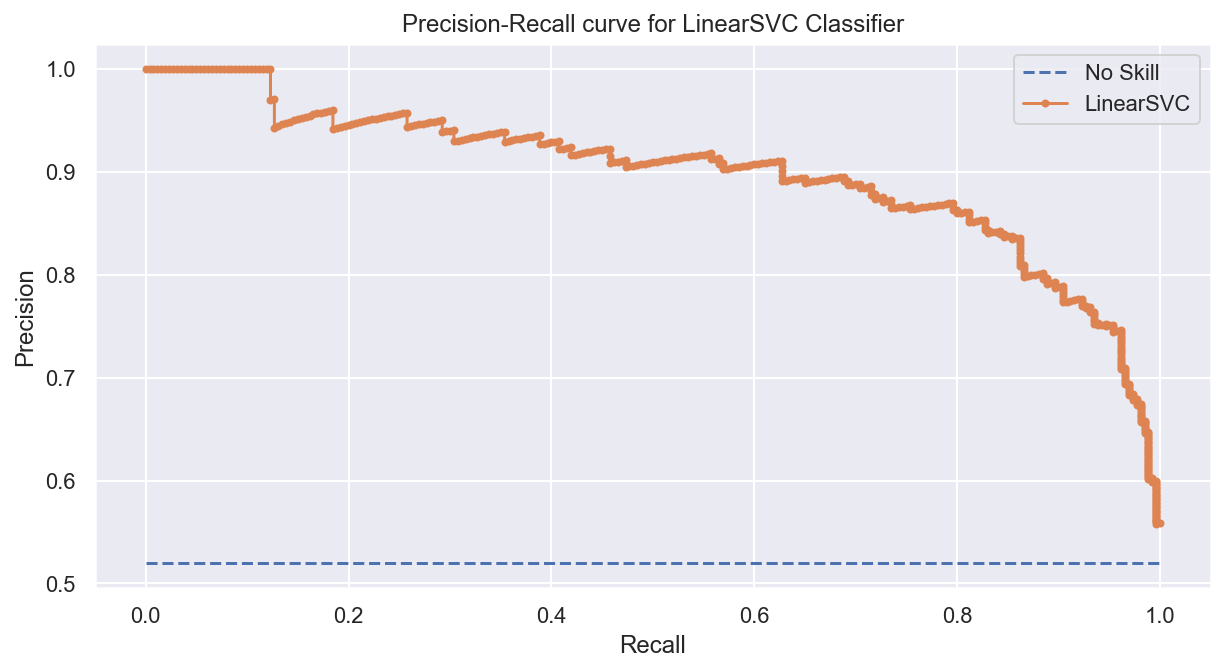

In [222]:
# precision-recall curve and f1
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot
# generate 2 class dataset
X, y = make_classification(n_samples=1000, n_classes=2, random_state=1)
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)
# fit a model
# model = LogisticRegression(solver='lbfgs')

# use our model
model = model_svc

model.fit(trainX, trainy)
# predict probabilities
lr_probs = model._predict_proba_lr(testX)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# predict class values
yhat = model.predict(testX)
lr_precision, lr_recall, _ = precision_recall_curve(testy, lr_probs)
lr_f1, lr_auc = f1_score(testy, yhat), auc(lr_recall, lr_precision)
# summarize scores
print('LinearSVC: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(testy[testy==1]) / len(testy)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='LinearSVC')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.title('Precision-Recall curve for LinearSVC Classifier')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

The precision-recall curve plot show the precision/recall for each threshold for a Linear Support Vector Classifier model (orange) compared to a no skill model (blue).

## When to Use ROC vs. Precision-Recall Curves?

Again from https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

Generally, the use of ROC curves and precision-recall curves are as follows:

- ROC curves should be used when there are roughly equal numbers of observations for each class.
- Precision-Recall curves should be used when there is a moderate to large class imbalance.

The reason for this recommendation is that ROC curves present an optimistic picture of the model on datasets with a class imbalance.

Some go further and suggest that using a ROC curve with an imbalanced dataset might be deceptive and lead to incorrect interpretations of the model skill.

The main reason for this optimistic picture is because of the use of true negatives in the False Positive Rate in the ROC Curve and the careful avoidance of this rate in the Precision-Recall curve.

## As our dataset is very very balanced, we will lean towards ROC.

## Learning Curves: LinearSVC

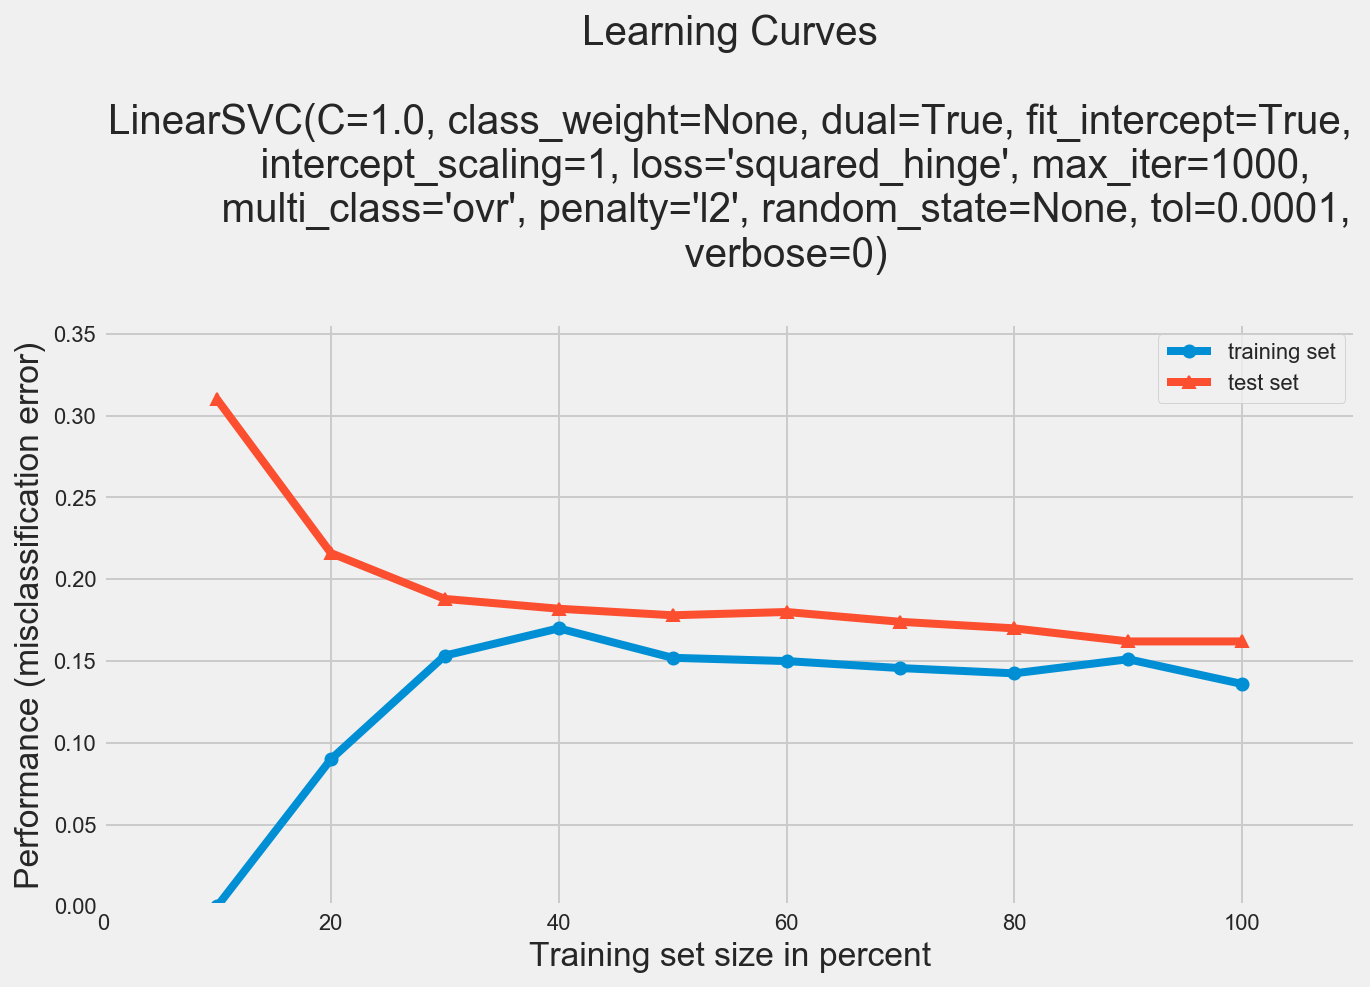

In [224]:
from mlxtend.plotting import plot_learning_curves
#plot_learning_curves(X_train, y_train, X_test, y_test, model_svc)
plot_learning_curves(trainX, trainy, testX, testy, model_svc)
plt.show()

# ============================

# Logistic Regression

We'll do the same metrics for Logistic Regression as we did for LinearSVC


Confusion Matrix for Logistic Regression Model: 

[[113  76]
 [ 17 187]] 

Confusion Matrix for Logistic Regression Model as a little heatmap:


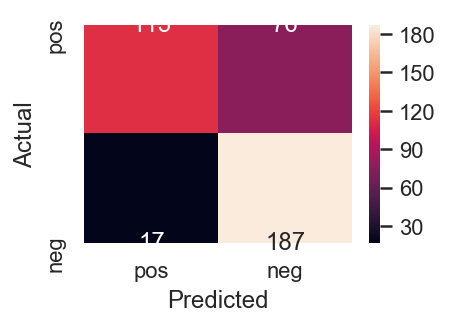


Precision, Recall, F1-scores for Logistic Regression Model: 

              precision    recall  f1-score   support

           0       0.87      0.60      0.71       189
           4       0.71      0.92      0.80       204

    accuracy                           0.76       393
   macro avg       0.79      0.76      0.75       393
weighted avg       0.79      0.76      0.76       393



In [226]:
model_lr = LogisticRegression(random_state=0)
model_lr.fit(X_train, y_train)
y_pred = model_lr.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
print('\nConfusion Matrix for Logistic Regression Model: \n')
print(conf_mat , '\n')
print('Confusion Matrix for Logistic Regression Model as a little heatmap:')
fig, ax = plt.subplots(figsize=(3,2))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=['pos','neg'], yticklabels=['pos','neg'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
print('\nPrecision, Recall, F1-scores for Logistic Regression Model:', '\n')
print(metrics.classification_report(y_test, y_pred, 
                                    target_names=['0','4']))

## ROC Curve: Logistic Regression Classifier

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.841

ROC curve for Logistic Regression Classifier:


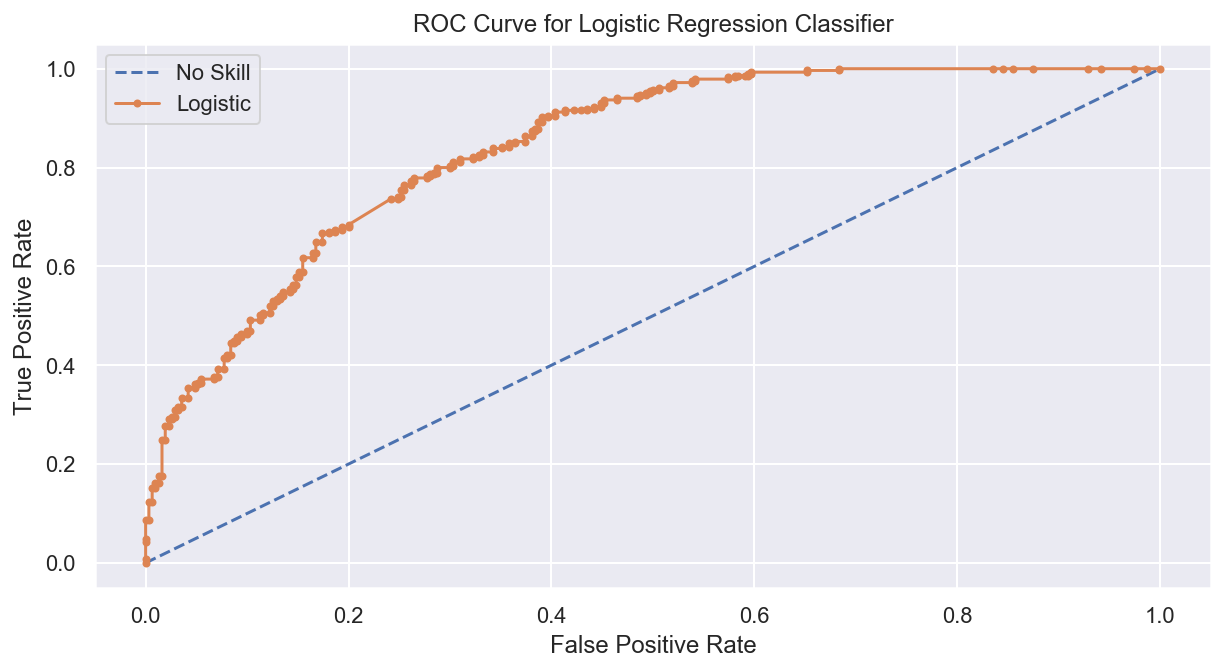

In [227]:
# Use our vectorized and feature-selected data
X = tv_matrix
y = df_sm['sentiment']

# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(testy))]

# use our model as defined above
model = model_lr

#LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)
# predict probabilities
lr_probs = model.predict_proba(testX)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
lr_auc = roc_auc_score(testy, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
print('\nROC curve for Logistic Regression Classifier:')
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs, pos_label=4)
lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs, pos_label=4)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title('ROC Curve for Logistic Regression Classifier')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

## Precision-Recall Curve: Logistic Regression

Logistic Regression: f1=0.841 auc=0.898


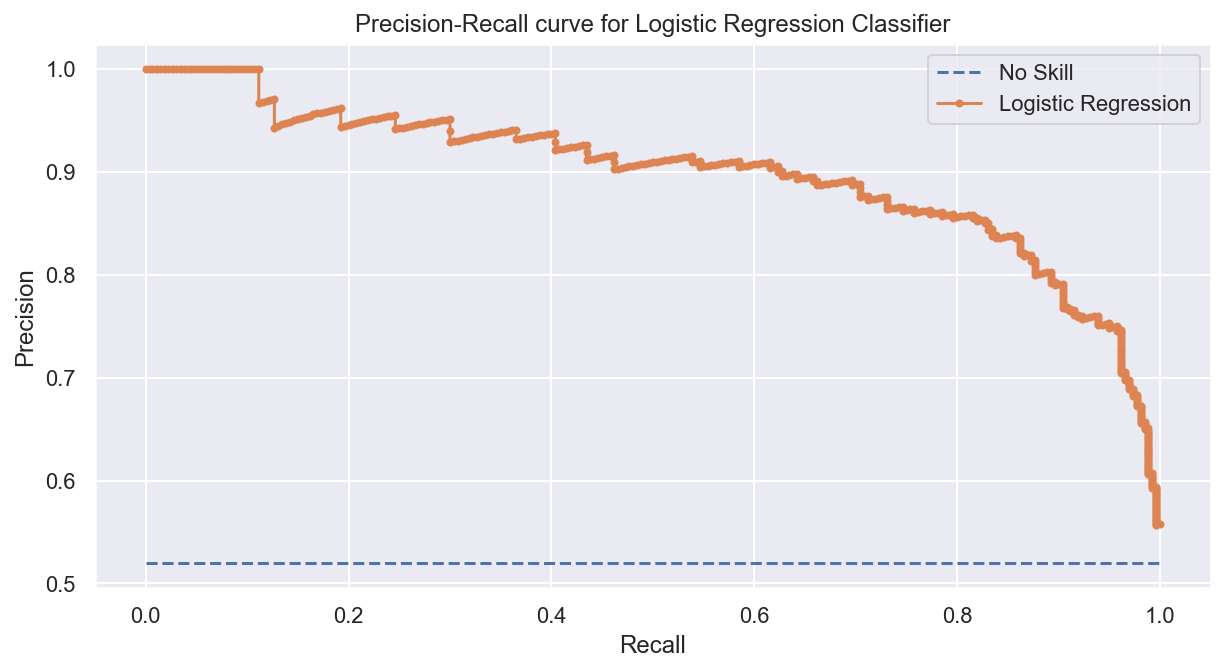

In [228]:
# generate 2 class dataset
X, y = make_classification(n_samples=1000, n_classes=2, random_state=1)
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)
# fit a model
# model = LogisticRegression(solver='lbfgs')

# use our model
model = model_lr

model.fit(trainX, trainy)
# predict probabilities
lr_probs = model.predict_proba(testX)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# predict class values
yhat = model.predict(testX)
lr_precision, lr_recall, _ = precision_recall_curve(testy, lr_probs)
lr_f1, lr_auc = f1_score(testy, yhat), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic Regression: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(testy[testy==1]) / len(testy)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic Regression')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.title('Precision-Recall curve for Logistic Regression Classifier')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

## Learning Curves: Logistic Regression

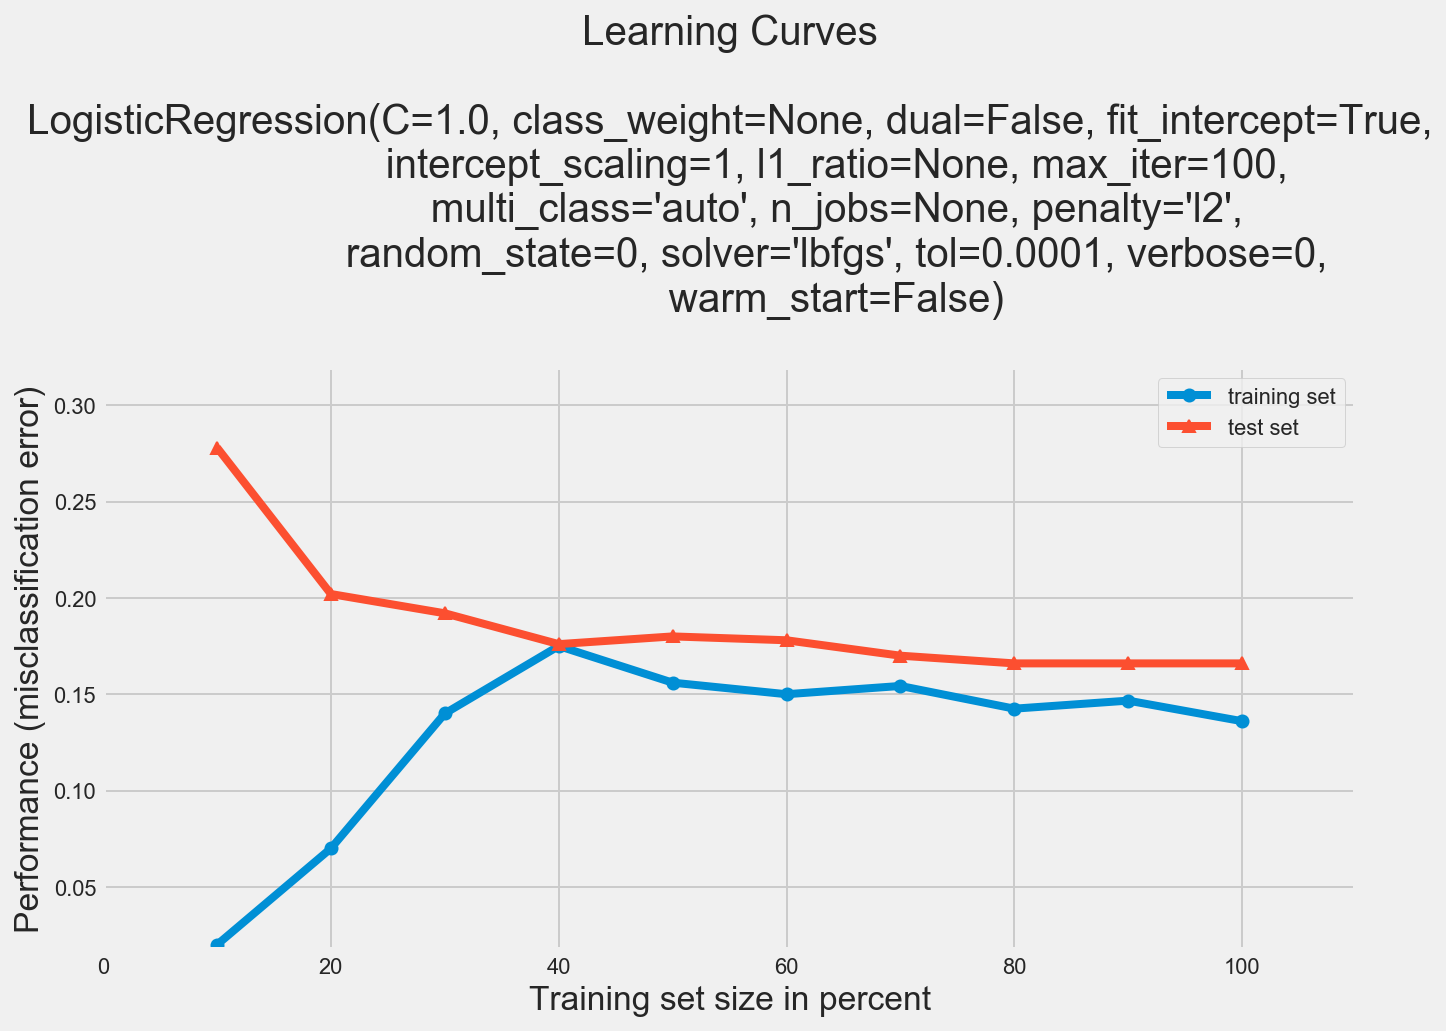

In [229]:
from mlxtend.plotting import plot_learning_curves
#plot_learning_curves(X_train, y_train, X_test, y_test, model_svc)
plot_learning_curves(trainX, trainy, testX, testy, model_lr)
plt.show()

# ===========================

# Multinomial NB Classifier

The <b>Multinomial Naive Bayes classifier</b> is suitable for classification with discrete features (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work.


Confusion Matrix for Multinomial Naive Bayes Classifier: 

[[152  37]
 [ 59 145]] 

Confusion Matrix for Multinomial Naive Bayes Classifier as a little heatmap:


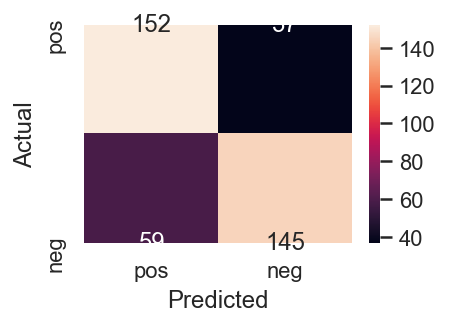


Precision, Recall, F1-scores for Multinomial Naive Bayes Classifier: 

              precision    recall  f1-score   support

           0       0.72      0.80      0.76       189
           4       0.80      0.71      0.75       204

    accuracy                           0.76       393
   macro avg       0.76      0.76      0.76       393
weighted avg       0.76      0.76      0.76       393



In [231]:
model_mnb = MultinomialNB()
model_mnb.fit(X_train, y_train)
y_pred = model_mnb.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
print('\nConfusion Matrix for Multinomial Naive Bayes Classifier: \n')
print(conf_mat , '\n')
print('Confusion Matrix for Multinomial Naive Bayes Classifier as a little heatmap:')
fig, ax = plt.subplots(figsize=(3,2))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=['pos','neg'], yticklabels=['pos','neg'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
print('\nPrecision, Recall, F1-scores for Multinomial Naive Bayes Classifier:', '\n')
print(metrics.classification_report(y_test, y_pred, 
                                    target_names=['0','4']))

# ROC and AUC: MultinomialNB

As with above.

No Skill: ROC AUC=0.500
MultinomialNB: ROC AUC=0.837

ROC Curve for MultinomialNB:


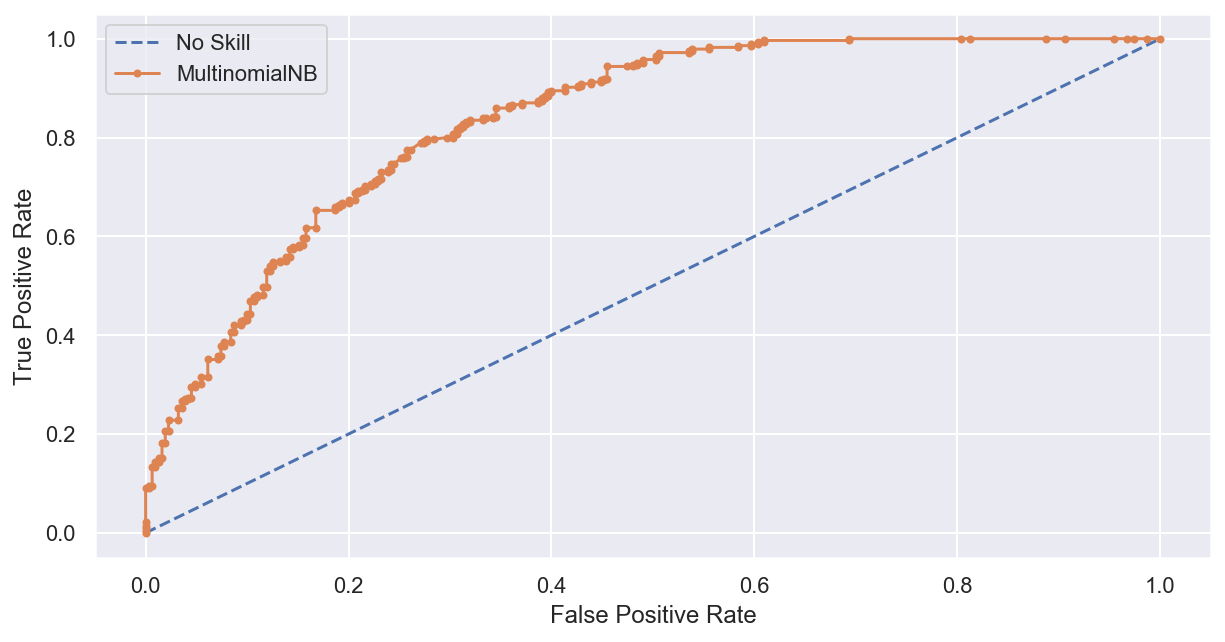

In [232]:
# Use our vectorized and feature-selected data
X = tv_matrix
y = df_sm['sentiment']

# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(testy))]

# use our model as defined above
model = model_mnb

#LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)
# predict probabilities
lr_probs = model.predict_proba(testX)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
lr_auc = roc_auc_score(testy, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('MultinomialNB: ROC AUC=%.3f' % (lr_auc))
print('\nROC Curve for MultinomialNB:')
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs, pos_label=4)
lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs, pos_label=4)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='MultinomialNB')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

## Learning Curves: MultinomialNB

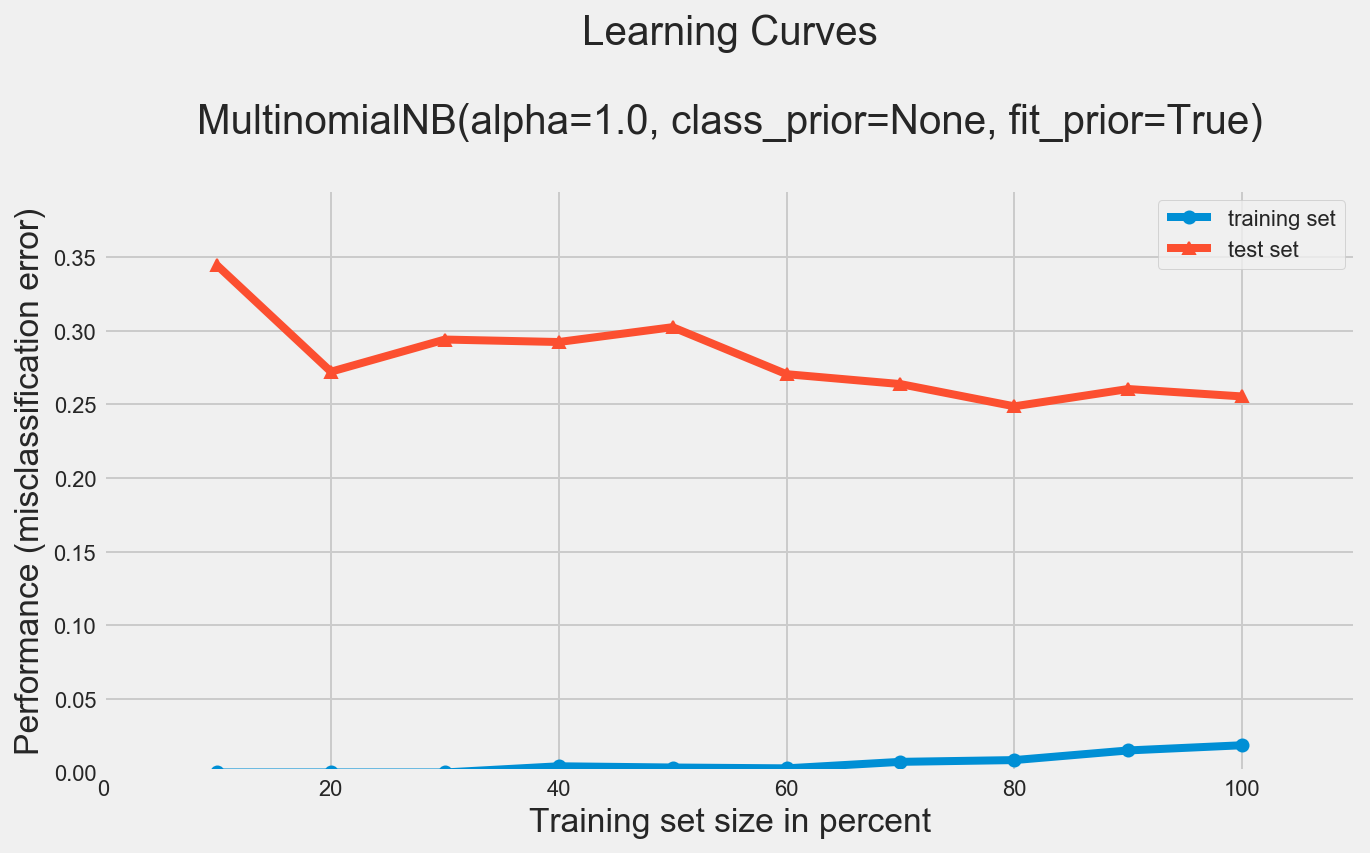

In [233]:

plot_learning_curves(trainX, trainy, testX, testy, model_mnb)
plt.show()

# ===============================================

# Random Forest Classifier

It did perform poorly on the "accuracy" comparison, especially with the really small dataset, but as we've seen above, accuracy is a poor predictor of other performance measures.


Confusion Matrix for Random Forest Classifier: 

[[ 92  97]
 [ 10 194]] 

Confusion Matrix for Random Forest Classifier as a little heatmap:


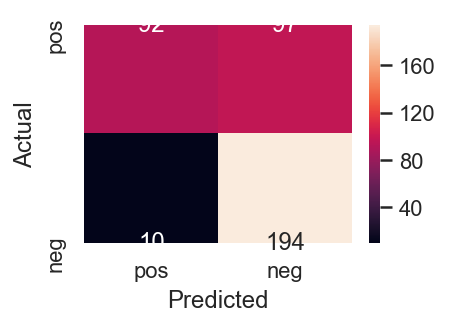


Precision, Recall, F1-scores for Random Forest Classifier Classifier: 

              precision    recall  f1-score   support

           0       0.90      0.49      0.63       189
           4       0.67      0.95      0.78       204

    accuracy                           0.73       393
   macro avg       0.78      0.72      0.71       393
weighted avg       0.78      0.73      0.71       393



In [234]:
model_rfc = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=0)
#model_mnb = MultinomialNB()
model_rfc.fit(X_train, y_train)
y_pred = model_rfc.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
print('\nConfusion Matrix for Random Forest Classifier: \n')
print(conf_mat , '\n')
print('Confusion Matrix for Random Forest Classifier as a little heatmap:')
fig, ax = plt.subplots(figsize=(3,2))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=['pos','neg'], yticklabels=['pos','neg'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
print('\nPrecision, Recall, F1-scores for Random Forest Classifier Classifier:', '\n')
print(metrics.classification_report(y_test, y_pred, 
                                    target_names=['0','4']))

Okay! That is our worst one so far, both in terms of accuracy AND f1-score. Let's do the ROC curve!

## ROC Curve and AUC metric: Random Forest

No Skill: ROC AUC=0.500
Random Forest Classifier: ROC AUC=0.821

ROC Curve for Random Forest Classifier:


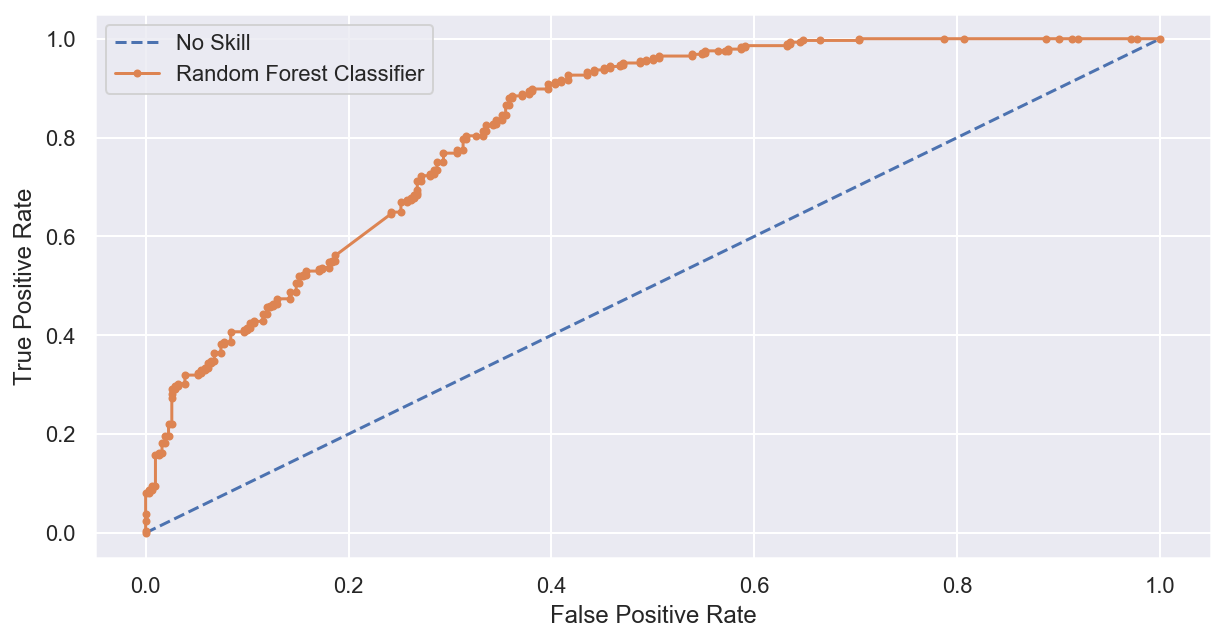

In [235]:
# Use our vectorized and feature-selected data
X = tv_matrix
y = df_sm['sentiment']

# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(testy))]

# use our model as defined above
model = model_rfc

#LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)
# predict probabilities
lr_probs = model.predict_proba(testX)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
lr_auc = roc_auc_score(testy, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Random Forest Classifier: ROC AUC=%.3f' % (lr_auc))
print('\nROC Curve for Random Forest Classifier:')
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs, pos_label=4)
lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs, pos_label=4)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Random Forest Classifier')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

## Learning Curve: Random Forest

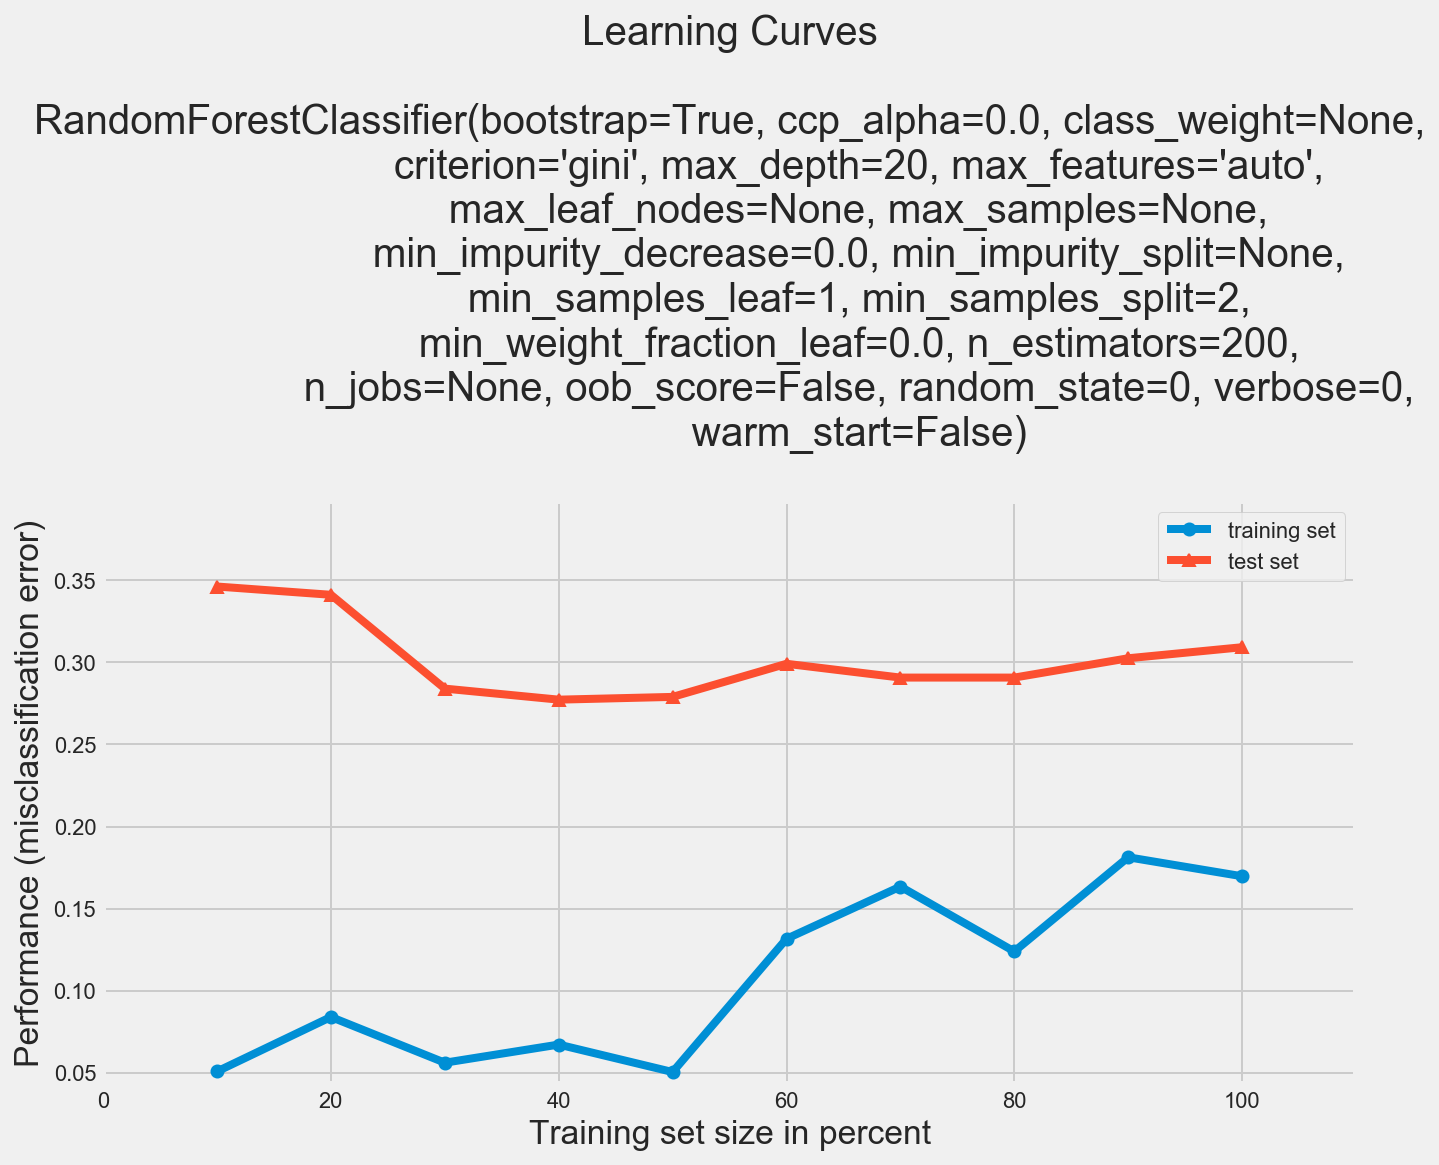

In [236]:
from mlxtend.plotting import plot_learning_curves
#plot_learning_curves(X_train, y_train, X_test, y_test, model_svc)
plot_learning_curves(trainX, trainy, testX, testy, model_rfc)
plt.show()

## Interesting points of comparison!!

Early in this project, I was doing sentiment predictions with Afinn, to be used as a baseline later. At our first arrival at this point, things are looking better already!

#### Weighted Avg F1-Scores
-----------------------------------

0.63 - Afinn original values.

0.70 - Logistic Regression, 800 rows total, Tf-idf encoding

0.74 - LinearSVC, 800 rows total, Tf-idf encoding


# ============================

# Ensembling

# ============================

Ensemble methods are meta-algorithms that combine several machine learning techniques into one predictive model in order to decrease variance (bagging), bias (boosting), or improve predictions (stacking). Ensemble methods can be divided into two groups: sequential ensemble methods where the base learners are generated sequentially (e.g. AdaBoost) and parallel ensemble methods where the base learners are generated in parallel (e.g. Random Forest). The basic motivation of sequential methods is to exploit the dependence between the base learners since the overall performance can be boosted by weighing previously mislabeled examples with higher weight. The basic motivation of parallel methods is to exploit independence between the base learners since the error can be reduced dramatically by averaging.

Most ensemble methods use a single base learning algorithm to produce homogeneous base learners, i.e. learners of the same type leading to homogeneous ensembles. There are also some methods that use heterogeneous learners, i.e. learners of different types, leading to heterogeneous ensembles. In order for ensemble methods to be more accurate than any of its individual members the base learners have to be as accurate as possible and as diverse as possible.

### Bagging

Bagging stands for <b>bootstrap aggregation</b>. One way to reduce the variance of an estimate is to average together multiple estimates. For example, we can train $M$ different trees $f_m$ on different subsets of the data (chosen randomly with replacement) and compute the ensemble:

\begin{equation}
   f(x) = \frac{1}{M}\sum_{m=1}^{M}f_m(x) 
\end{equation}

<b>Translation:</b> <i><u>The final result is the average of the M sub-results.</u></i>

Bagging uses bootstrap sampling to obtain the data subsets for training the base learners. For aggregating the outputs of base learners, bagging uses voting for classification and averaging for regression.

In [153]:
%matplotlib inline

import itertools
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn import datasets

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score, train_test_split

from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions

np.random.seed(0)

In [154]:
# X, y = iris.data[:, 0:2], iris.target

X = tv_matrix
y = np.array(df_sm['sentiment'])
    
clf1 = DecisionTreeClassifier(criterion='entropy', max_depth=1)
clf2 = KNeighborsClassifier(n_neighbors=1)    

bagging1 = BaggingClassifier(base_estimator=clf1, n_estimators=10, max_samples=0.8, max_features=0.8)
bagging2 = BaggingClassifier(base_estimator=clf2, n_estimators=10, max_samples=0.8, max_features=0.8)

Accuracy: 0.63 (+/- 0.02) [Decision Tree]
Accuracy: 0.66 (+/- 0.02) [K-NN]
Accuracy: 0.63 (+/- 0.02) [Bagging Tree]
Accuracy: 0.56 (+/- 0.01) [Bagging K-NN]


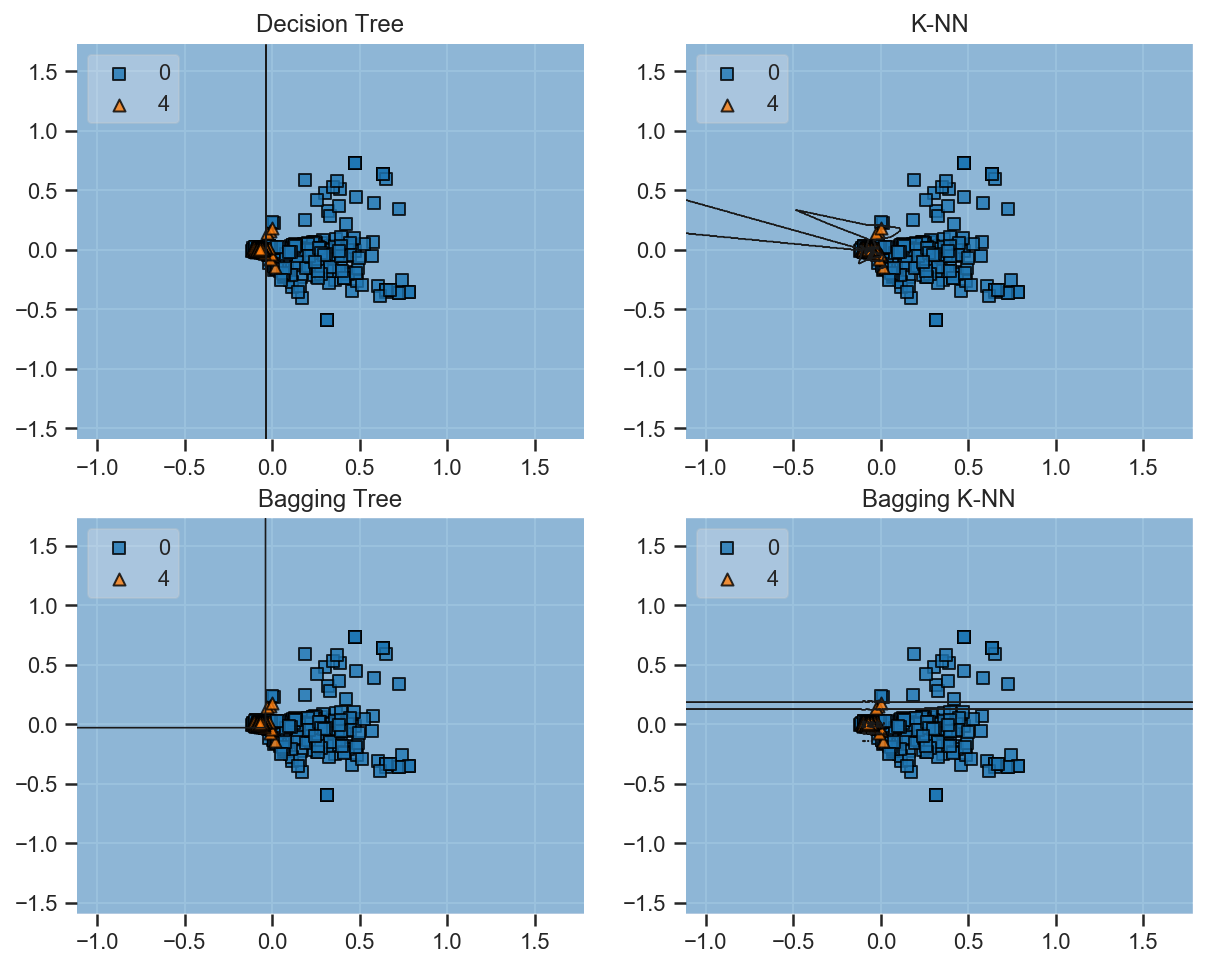

In [155]:
from sklearn.decomposition import PCA

label = ['Decision Tree', 'K-NN', 'Bagging Tree', 'Bagging K-NN']
clf_list = [clf1, clf2, bagging1, bagging2]

fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

for clf, label, grd in zip(clf_list, label, grid):        
    scores = cross_val_score(clf, X, y, cv=3, scoring='accuracy')
    
    
    print("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))
        
    #clf.fit(X, y)
    
    pca = PCA(n_components = 2)
    X_flattened = pca.fit_transform(X)
    #clf.fit(X_flattened, y)
    #clf.fit(X, y)
    clf.fit(X_flattened, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X_flattened, y=y, clf=clf, legend=2)
    plt.title(label)
    

    #plot_decision_regions(X_train2, y_train, clf=clf, legend=2)

plt.show()

The figure above shows the decision boundary of a decision tree and k-NN classifiers along with their bagging ensembles applied to the Iris dataset. The decision tree shows axes parallel boundaries while the $k=1$ nearest neighbors fits closely to the data points. The bagging ensembles were trained using $10$ base estimators with $0.8$ subsampling of training data and $0.8$ subsampling of features. The decision tree bagging ensemble achieved higher accuracy in comparison to k-NN bagging ensemble because k-NN are less sensitive to perturbation on training samples and therefore they are called *stable learners*. Combining stable learners is less advantageous since the ensemble will not help improve generalization performance.

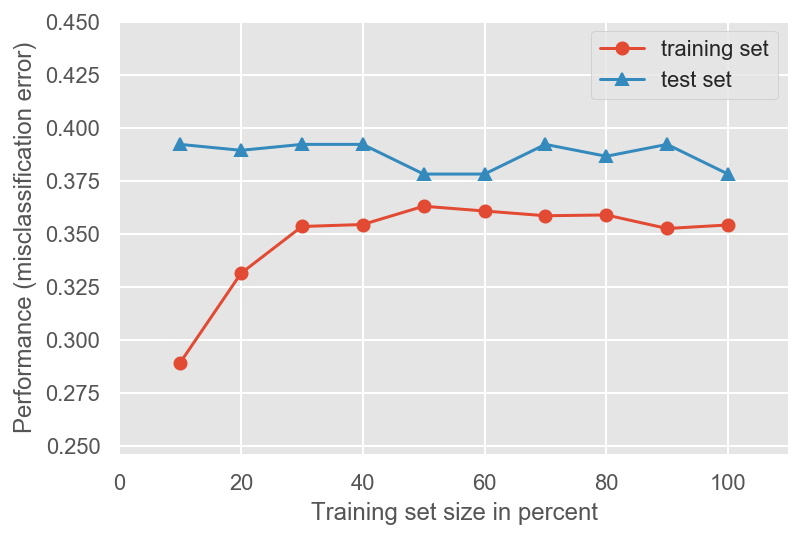

In [156]:
#plot learning curves
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
plt.figure()
plot_learning_curves(X_train, y_train, X_test, y_test, bagging1, print_model=False, style='ggplot')
plt.show()

The figure above shows learning curves for the bagging tree ensemble. We can see an average error of  0.35  on the training data and a U-shaped error curve for the testing data. The smallest gap between training and test errors occurs at around  80%  of the training set size.

In [105]:
#Ensemble Size
# num_est = map(int, np.linspace(1,100,20))
num_est = np.linspace(1,100,20).astype(int)
bg_clf_cv_mean = []
bg_clf_cv_std = []
for n_est in num_est:    
    bg_clf = BaggingClassifier(base_estimator=clf1, n_estimators=n_est, max_samples=0.8, max_features=0.8)
    scores = cross_val_score(bg_clf, X, y, cv=3, scoring='accuracy')
    bg_clf_cv_mean.append(scores.mean())
    bg_clf_cv_std.append(scores.std())

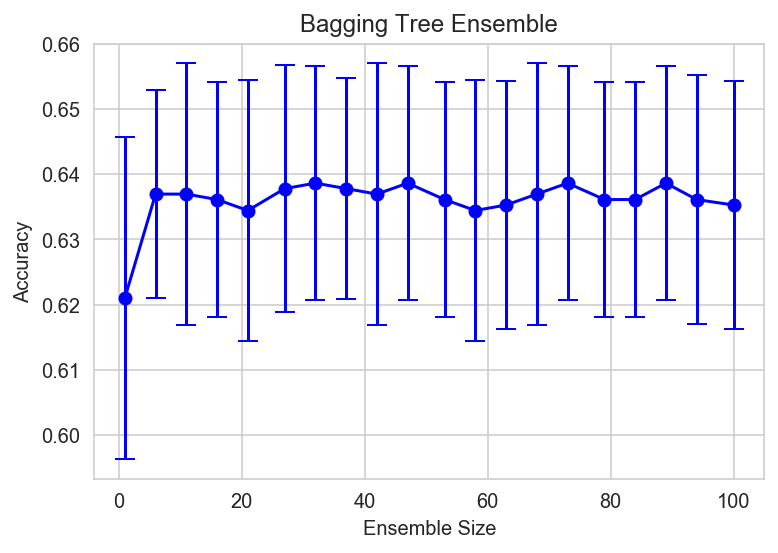

In [106]:
plt.figure()
(_, caps, _) = plt.errorbar(num_est, bg_clf_cv_mean, yerr=bg_clf_cv_std, c='blue', fmt='-o', capsize=5)
# caps = plt.errorbar(num_est, bg_clf_cv_mean, yerr=bg_clf_cv_std, c='blue', fmt='-o', capsize=5)
for cap in caps:
    cap.set_markeredgewidth(1)                                                                                                                                
plt.ylabel('Accuracy'); plt.xlabel('Ensemble Size'); plt.title('Bagging Tree Ensemble');
plt.show()

The figure above shows how the test accuracy improves with the size of the ensemble. Based on cross-validation results, we can see the accuracy increases until approximately $10$ base estimators and then plateaus afterwards. Thus, adding base estimators beyond $10$ only increases computational complexity without accuracy gains for the Sentiment140 dataset.

----------------------

## Boosting

Boosting refers to a family of algorithms that are able to convert weak learners to strong learners. The main principle of boosting is to fit a sequence of weak learners (models that are only slightly better than random guessing, such as small decision trees) to weighted versions of the data, where more weight is given to examples that were mis-classified by earlier rounds. The predictions are then combined through a weighted majority vote (classification) or a weighted sum (regression) to produce the final prediction. The principal difference between boosting and the committee methods such as bagging is that base learners are trained in sequence on a weighted version of the data.

In [107]:
import itertools
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn import datasets

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score, train_test_split

from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions

In [127]:
X = tv_matrix
y = np.array(df_sm['sentiment'])

clf = DecisionTreeClassifier(criterion='entropy', max_depth=1)

num_est = [1, 2, 3, 10]
label = ['AdaBoost (n_est=1)', 'AdaBoost (n_est=2)', 'AdaBoost (n_est=3)', 'AdaBoost (n_est=10)']

In [128]:
len(X)

1190

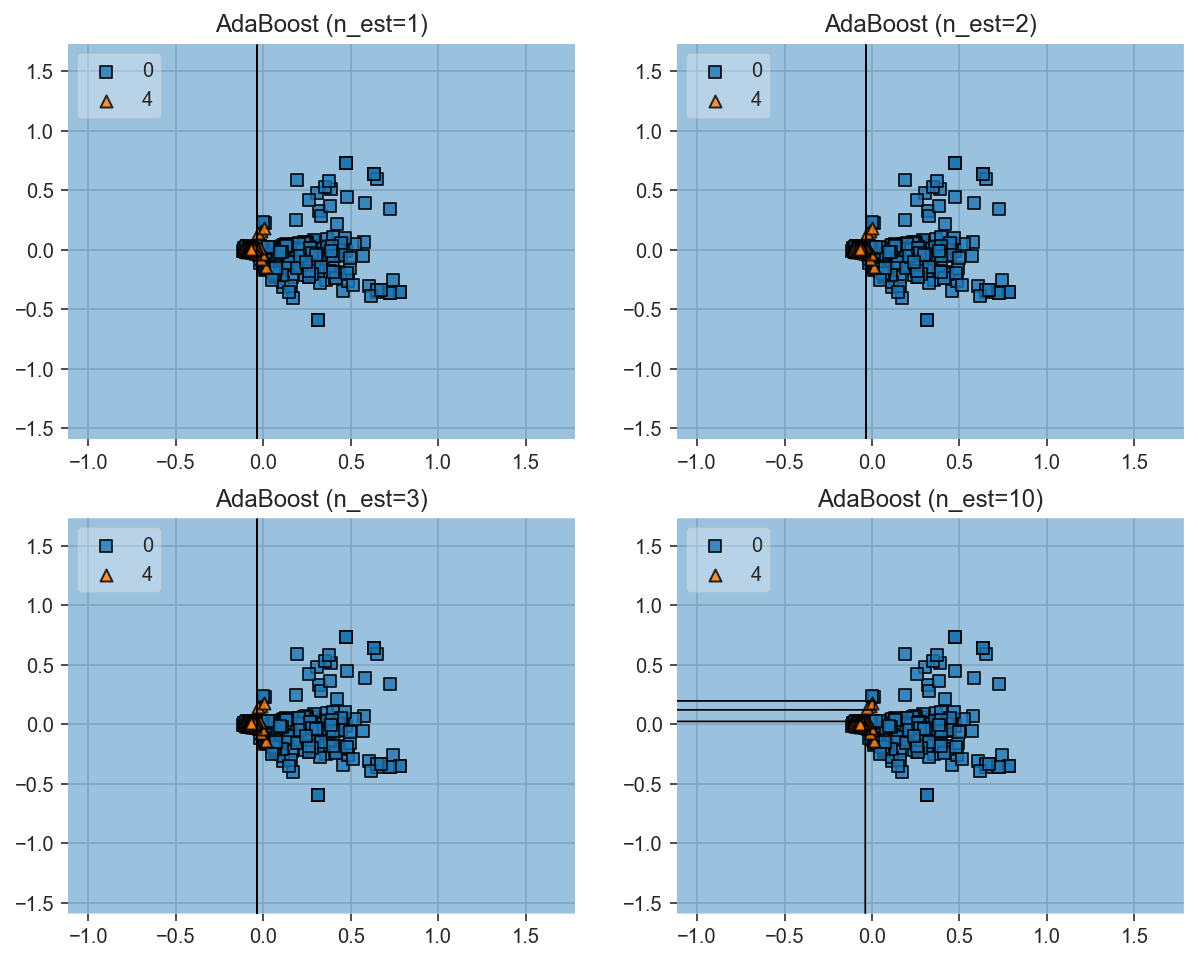

In [129]:
fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

for n_est, label, grd in zip(num_est, label, grid):     
    boosting = AdaBoostClassifier(base_estimator=clf, n_estimators=n_est)
    pca = PCA(n_components = 2)
    X_flattened = pca.fit_transform(X)
    boosting.fit(X_flattened, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X_flattened, y=y, clf=boosting, legend=2)
    plt.title(label)

plt.show()

The AdaBoost algorithm is illustrated in the figure above. Each base learner consists of a decision tree with depth $1$, thus classifying the data based on a feature threshold that partitions the space into two regions separated by a linear decision surface that is parallel to one of the axes.

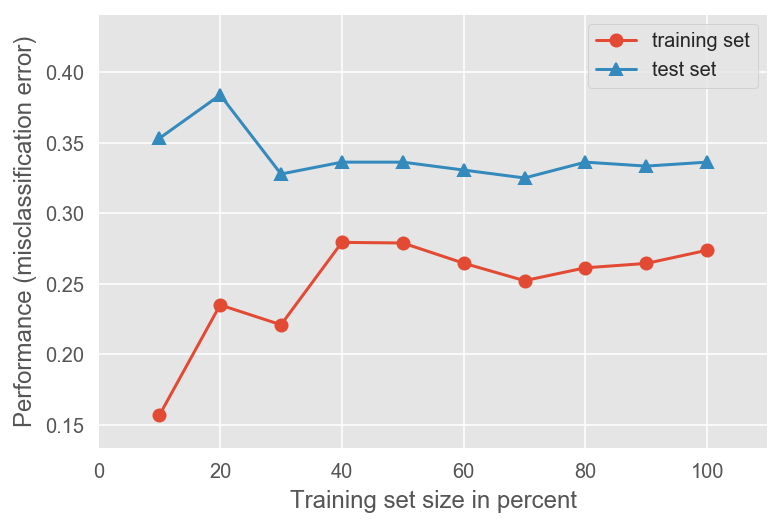

In [111]:
#plot learning curves
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

boosting = AdaBoostClassifier(base_estimator=clf, n_estimators=10)
        
plt.figure()
plot_learning_curves(X_train, y_train, X_test, y_test, boosting, print_model=False, style='ggplot')
plt.show()

In [112]:
#Ensemble Size
#num_est = map(int, np.linspace(1,100,20))
num_est = np.linspace(1,100,20).astype(int)
bg_clf_cv_mean = []
bg_clf_cv_std = []
for n_est in num_est:
    ada_clf = AdaBoostClassifier(base_estimator=clf, n_estimators=n_est)
    scores = cross_val_score(ada_clf, X, y, cv=3, scoring='accuracy')
    bg_clf_cv_mean.append(scores.mean())
    bg_clf_cv_std.append(scores.std())

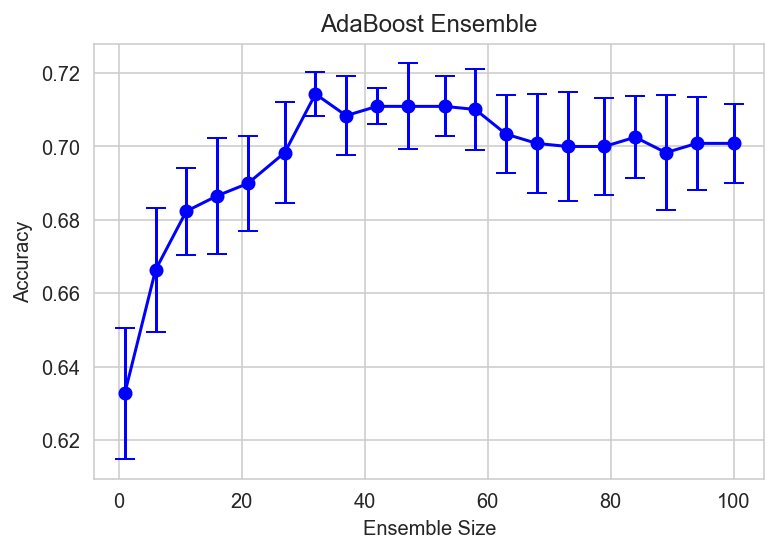

In [113]:
plt.figure()
(_, caps, _) = plt.errorbar(num_est, bg_clf_cv_mean, yerr=bg_clf_cv_std, c='blue', fmt='-o', capsize=5)
for cap in caps:
    cap.set_markeredgewidth(1)                                                                                                                                
plt.ylabel('Accuracy'); plt.xlabel('Ensemble Size'); plt.title('AdaBoost Ensemble');
plt.show()

----------------

## Stacking

Stacking is an ensemble learning technique that combines multiple classification or regression models via a meta-classifier or a meta-regressor. The base level models are trained based on complete training set then the meta-model is trained on the outputs of base level model as features. The base level often consists of different learning algorithms and therefore stacking ensembles are often heterogeneous.

In [114]:
import itertools
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn import datasets

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingClassifier

from sklearn.model_selection import cross_val_score, train_test_split

from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions

In [115]:
X = tv_matrix
y = np.array(df_sm['sentiment'])

clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
lr = LogisticRegression()
sclf = StackingClassifier(classifiers=[clf1, clf2, clf3], 
                          meta_classifier=lr)

Accuracy: 0.66 (+/- 0.02) [KNN]
Accuracy: 0.66 (+/- 0.03) [Random Forest]
Accuracy: 0.68 (+/- 0.02) [Naive Bayes]
Accuracy: 0.64 (+/- 0.03) [Stacking Classifier]


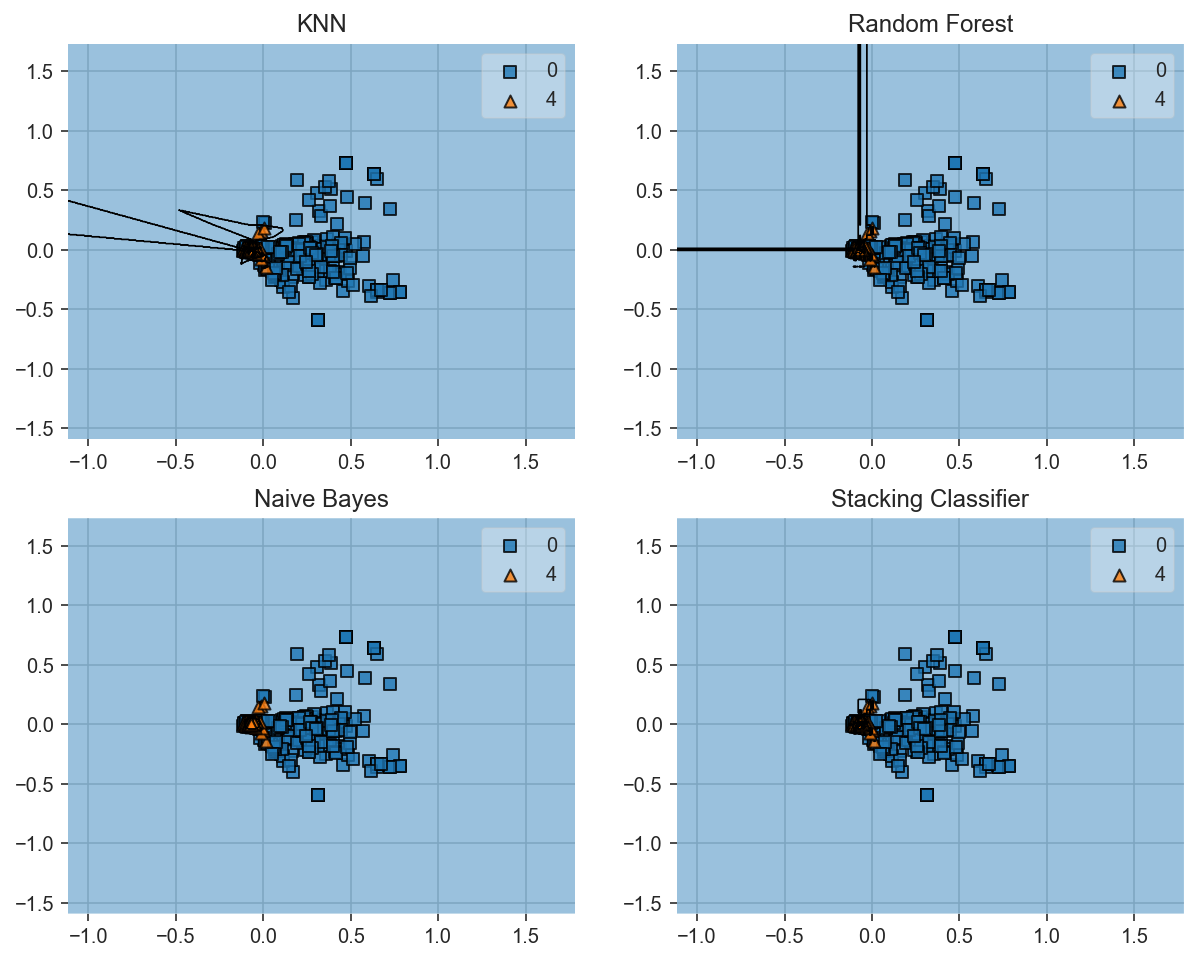

In [116]:
label = ['KNN', 'Random Forest', 'Naive Bayes', 'Stacking Classifier']
clf_list = [clf1, clf2, clf3, sclf]
    
fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

clf_cv_mean = []
clf_cv_std = []
for clf, label, grd in zip(clf_list, label, grid):
    
    pca = PCA(n_components = 2)
    X_flattened = pca.fit_transform(X)
        
    scores = cross_val_score(clf, X_flattened, y, cv=3, scoring='accuracy')
    print("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))
    clf_cv_mean.append(scores.mean())
    clf_cv_std.append(scores.std())
        
    clf.fit(X_flattened, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X_flattened, y=y, clf=clf)
    plt.title(label)

plt.show()

The stacking ensemble is illustrated in the figure above. It consists of k-NN, Random Forest and Naive Bayes base classifiers whose predictions are combined by Lostic Regression as a meta-classifier. We can see the blending of decision boundaries achieved by the stacking classifier.

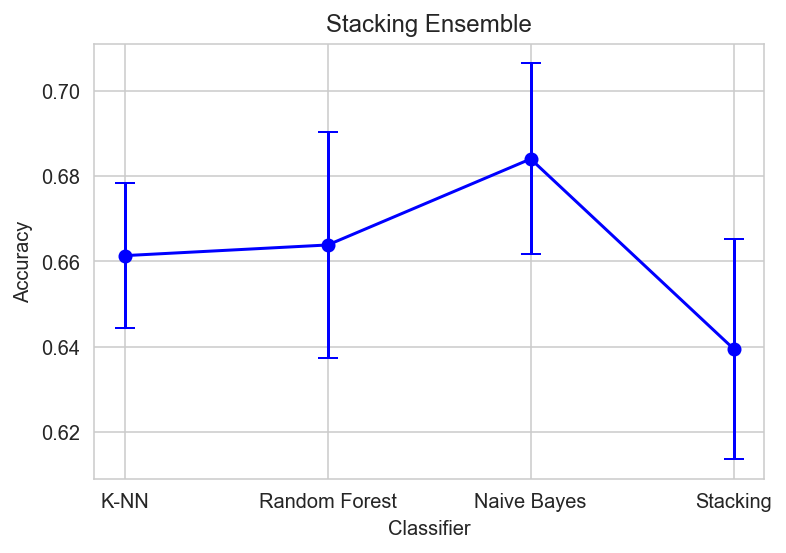

In [117]:
#plot classifier accuracy    
plt.figure()
(_, caps, _) = plt.errorbar(range(4), clf_cv_mean, yerr=clf_cv_std, c='blue', fmt='-o', capsize=5)
for cap in caps:
    cap.set_markeredgewidth(1)                                                                                                                                
plt.xticks(range(4), ['K-NN', 'Random Forest', 'Naive Bayes', 'Stacking'])        
plt.ylabel('Accuracy'); plt.xlabel('Classifier'); plt.title('Stacking Ensemble');
plt.show()

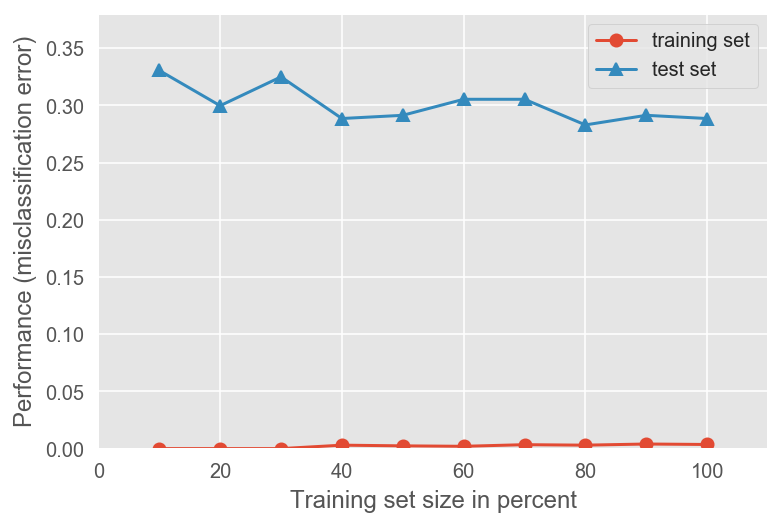

In [118]:
#plot learning curves
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
plt.figure()
plot_learning_curves(X_train, y_train, X_test, y_test, sclf, print_model=False, style='ggplot')
plt.show()

All for today.

---------------------

-----------------------

-----------------------

----------------------

----------------------

---------------------
#
#
#
### End of working working file.
#
#
#

## Sentiment Analysis with Afinn

As a quick and dirty sanity check, I've set up Afinn in the early stages of data cleaning, and intend to keep a little record of Afinn's performance, as I increase the rigour of the data cleaning.

In [119]:
from afinn import Afinn

afn = Afinn(emoticons=True)

In [120]:
texts = np.array(df_sm['text_nav'])
sentiments = np.array(df_sm['sentiment'])

# extract data for model evaluation
#train_texts = texts[:10000]
#train_sentiments = sentiments[:10000]

#test_texts = texts[40000:60000]
#test_sentiments = sentiments[40000:60000]
sample_ids = [626, 533, 310, 123, 654, 400]

In [121]:
#for text_clean, sentiment in zip(texts[sample_ids], sentiments[sample_ids]):
#    print('TEXT:', texts)
#    print('Actual Sentiment:', sentiment)
#    print('Predicted Sentiment polarity:', afn.score(texts))
#    print('-'*60)

In [122]:
# Predict sentiment with Afinn

#sentiment_polarity = [afn.score(Text) for Text in normalized_texts]
#predicted_sentiments = ['positive' if score >= 1.0 else 'negative' for score in sentiment_polarity]
#predicted_sentiments = [4 if score >= 1.0 else 0 for score in sentiment_polarity]

In [123]:
#meu.display_model_performance_metrics(true_labels=test_texts, predicted_labels=predicted_sentiments, 
#                                  classes=['positive', 'negative'])
#meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=predicted_sentiments, 
#                                  classes=[4, 0])

## Checking cleaning with Afinn

I'm curious about how deeper cleaning affects predicitive models. So I set up Afinn after the very first round of data cleaning, and am going to track results here in the markdown. For simplicity, I will monitor the effects of different levels of cleaning on "weighted avg f1-score"

Round 1, most basic cleaning, 20000 rows:  0.63

Round 2, include normalization, 20000 rows: 0.63

In [124]:
df_sm.head()

,sentiment,ID,Time,none,username,Text,text_clean,text_normalized,text_lemma,text_nouns,text_adjectives,text_verbs,text_nav,no_tokens
799399,0,2328964240,Thu Jun 25 10:11:30 PDT 2009,NO_QUERY,Sleevo86,Wow... Rest in peace Farrah Fawcett,Wow... Rest in peace Farrah Fawcett,wow . rest peace farrah fawcett,wow . rest peace farrah fawcett,peace farrah fawcett,,rest,peace farrah fawcett rest,6
799400,0,2328964537,Thu Jun 25 10:11:31 PDT 2009,NO_QUERY,dobbert21,How pissed am I that I'm missing most of Kevin Burkhardt's play-by-play for work? Very,How pissed am I that I'm missing most of Kevin Burkhardt's play-by-play for work? Very,pissed im missing kevin burkhardts play - - play work ?,piss -PRON- be miss kevin burkhardts play - - play work ?,kevin burkhardts play work,,piss be miss play,kevin burkhardts play work piss be miss play,12
799401,0,2328964564,Thu Jun 25 10:11:31 PDT 2009,NO_QUERY,queenjord,So sad to hear farrah fawcett died,So sad to hear farrah fawcett died,sad hear farrah fawcett died,sad hear farrah fawcett die,sad farrah fawcett,,hear die,sad farrah fawcett hear die,5
799402,0,2328964881,Thu Jun 25 10:11:32 PDT 2009,NO_QUERY,prosodic,"RIP Farrah Fawcett. I told my husband a couple days ago that I wondered if she'd live long enough to marry Ryan O'Neal. Sadly, no.","RIP Farrah Fawcett. I told my husband a couple days ago that I wondered if she'd live long enough to marry Ryan O'Neal. Sadly, no.","rip farrah fawcett told husband couple days ago wondered shed live long enough marry ryan ' neal . sadly , .","rip farrah fawcett tell husband couple day ago wonder shed live long enough marry ryan ' neal . sadly , .",farrah fawcett husband couple day marry ryan neal,,rip tell wonder shed,farrah fawcett husband couple day marry ryan neal rip tell wonder shed,21
799403,0,2328965091,Thu Jun 25 10:11:34 PDT 2009,NO_QUERY,dj_diva,@djt_elle &lt;---sadder face cause you leaving and we never hooked up,elle <---sadder face cause you leaving and we never hooked up,elle -- sadder face cause leaving never hooked,elle -- sad face cause leave never hook,elle face cause,sad,leave hook,elle face cause sad leave hook,8


## Save to database

In [125]:
#df.to_sql('df_sm', con)